In [1]:
# Bloque para Cargar y Descomprimir Datos desde Google Drive

# Paso 1: Conectar Google Drive
from google.colab import drive
drive.mount('/content/drive')

import zipfile
import os

zip_path = '/content/drive/MyDrive/respaldo/mastr1325.zip' # Ruta a tu archivo ZIP en Drive
extract_path = 'mastr1325' # Carpeta donde se extraerán los archivos en Colab
# ---------------------------

# Crear el directorio destino si no existe
if not os.path.exists(extract_path):
    os.makedirs(extract_path)

# Descomprimir el archivo
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Archivos extraídos en la carpeta: {extract_path}")

#archivos extraídos para verificar
print("\nContenido extraído:")
!ls {extract_path}

Mounted at /content/drive
Archivos extraídos en la carpeta: mastr1325

Contenido extraído:
mastr1325


In [2]:
import cv2
import time
import math
import numpy as np
import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, concatenate, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.utils import Sequence

In [3]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generador de datos para Keras, carga imágenes desde el disco'
    def __init__(self, image_paths, mask_paths, batch_size=8, dim=(256, 256), n_channels=3, n_classes=4, shuffle=True):
        'Inicialización'
        self.dim = dim
        self.batch_size = batch_size
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denota el número de batches por época'
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        'Genera un batch de datos'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_image_paths = [self.image_paths[k] for k in indexes]
        batch_mask_paths = [self.mask_paths[k] for k in indexes]
        X, y = self.__data_generation(batch_image_paths, batch_mask_paths)
        return X, y

    def on_epoch_end(self):
        'Actualiza los índices después de cada época'
        self.indexes = np.arange(len(self.image_paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_image_paths, batch_mask_paths):
        'Crea los datos de un batch (imágenes y máscaras)'
        X = np.empty((self.batch_size, *self.dim, self.n_channels), dtype=np.float32)
        y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=np.float32)

        for i, img_path in enumerate(batch_image_paths):
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            img = cv2.resize(img, self.dim)
            img = img / 255.0  # Normalizar
            X[i,] = img

            mask_path = batch_mask_paths[i]
            mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
            mask = cv2.resize(mask, self.dim, interpolation=cv2.INTER_NEAREST)

            mask[mask == 4] = 3#ajuste necesario para dataset mastr1325 con clases 0, 1, 2 y 4

            # Aplicar One-Hot Encoding
            mask_cat = tf.keras.utils.to_categorical(mask, num_classes=self.n_classes)
            y[i,] = mask_cat

        return X, y

In [4]:
import os
import glob
from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split

base_dir = "/content/mastr1325/mastr1325/"
all_img_dir = os.path.join(base_dir, "JPEGImages")#JPEGImages
all_mask_dir = os.path.join(base_dir, "SegmentationClassRaw")

print(f"Buscando imágenes en: {all_img_dir}")
print(f"Buscando máscaras en: {all_mask_dir}")

all_img_paths = sorted(glob.glob(os.path.join(all_img_dir, "*.jpg")))
all_mask_paths = sorted(glob.glob(os.path.join(all_mask_dir, "*.png")))

print(f"Se encontraron {len(all_img_paths)} imágenes.")
print(f"Se encontraron {len(all_mask_paths)} máscaras.")

if len(all_img_paths) == 0 or len(all_img_paths) != len(all_mask_paths):
    print("\n¡ERROR! No se encontraron archivos o el número de imágenes no coincide con el de máscaras.")
    print("Verifica las rutas y las extensiones de archivo (.jpg, .png) e inténtalo de nuevo.")
else:
    print("\n¡Perfecto! Imágenes y máscaras coinciden.")


## Dividir las listas en conjuntos de train y val
train_img_paths, val_img_paths, train_mask_paths, val_mask_paths = train_test_split(
    all_img_paths,
    all_mask_paths,
    test_size=0.2,
    random_state=42  # Para que la división sea reproducible
)

print(f"\nDatos divididos en:")
print(f"  - Entrenamiento: {len(train_img_paths)} imágenes/máscaras")
print(f"  - Validación: {len(val_img_paths)} imágenes/máscaras")

Buscando imágenes en: /content/mastr1325/mastr1325/JPEGImages
Buscando máscaras en: /content/mastr1325/mastr1325/SegmentationClassRaw
Se encontraron 1325 imágenes.
Se encontraron 1325 máscaras.

¡Perfecto! Imágenes y máscaras coinciden.

Datos divididos en:
  - Entrenamiento: 1060 imágenes/máscaras
  - Validación: 265 imágenes/máscaras


In [5]:
##Crear los Generadores para U-net
BATCH_SIZE = 8
N_CLASSES = 4  # (Obstacles and environment = 0, Water = 1, Sky = 2, Ignore region / unknown category = 4)
IMG_DIM = (256, 256)

train_generator = DataGenerator(
    image_paths=train_img_paths,
    mask_paths=train_mask_paths,
    batch_size=BATCH_SIZE,
    dim=IMG_DIM,
    n_classes=N_CLASSES
)

val_generator = DataGenerator(
    image_paths=val_img_paths,
    mask_paths=val_mask_paths,
    batch_size=BATCH_SIZE,
    dim=IMG_DIM,
    n_classes=N_CLASSES
)

print(f"\nGenerador de Train listo con {len(train_generator)} lotes.")
print(f"Generador de Val listo con {len(val_generator)} lotes.")


Generador de Train listo con 132 lotes.
Generador de Val listo con 33 lotes.


In [6]:
def unet(input_size=(256, 256, 3), n_classes=3, n_filters=64):
    """
    Arquitectura U-Net para segmentación semántica, version dada en clase
    """

    # Entrada
    inputs = Input(input_size)

    # ------------------------- Encoder (Contracción) -------------------------
    # Bloque 1
    c1 = Conv2D(n_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Conv2D(n_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    # Bloque 2
    c2 = Conv2D(n_filters*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Conv2D(n_filters*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bloque 3
    c3 = Conv2D(n_filters*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Conv2D(n_filters*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bloque 4
    c4 = Conv2D(n_filters*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Conv2D(n_filters*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # ------------------------- Nivel más profundo (Bottleneck) -------------------------
    c5 = Conv2D(n_filters*16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Conv2D(n_filters*16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # ------------------------- Decoder (Expansión) -------------------------
    # Bloque 6
    u6 = Conv2DTranspose(n_filters*8, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4]) # <-- Skip Connection
    u6 = Conv2D(n_filters*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    u6 = Conv2D(n_filters*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)

    # Bloque 7
    u7 = Conv2DTranspose(n_filters*4, (2, 2), strides=(2, 2), padding='same')(u6)
    u7 = concatenate([u7, c3]) # <-- Skip Connection
    u7 = Conv2D(n_filters*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    u7 = Conv2D(n_filters*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)

    # Bloque 8
    u8 = Conv2DTranspose(n_filters*2, (2, 2), strides=(2, 2), padding='same')(u7)
    u8 = concatenate([u8, c2]) # <-- Skip Connection
    u8 = Conv2D(n_filters*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    u8 = Conv2D(n_filters*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)

    # Bloque 9
    u9 = Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(u8)
    u9 = concatenate([u9, c1], axis=3) # <-- Skip Connection
    u9 = Conv2D(n_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    u9 = Conv2D(n_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)

    # Capa de salida
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(u9)  # Softmax para N clases

    model = Model(inputs=inputs, outputs=outputs)

    return model

print("Función unet() definida.")

Función unet() definida.


In [ ]:
import tensorflow as tf

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

IMG_DIM = (256, 256)
N_CLASSES = 4

# --- 2. Instanciar el modelo ---
model_unet = unet(input_size=(IMG_DIM[0], IMG_DIM[1], 3), n_classes=N_CLASSES)

# resumen de la arquitectura
print("Resumen del modelo:")
model_unet.summary()

Resumen del modelo:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 31,031,940 (118.38 MB)

 Trainable params: 31,031,940 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# --- Compilar el modelo ---
model_unet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=N_CLASSES)]
)

In [ ]:
# --- Definir Callbacks  ---

# (El formato .h5 guarda arquitectura, pesos y estado del optimizador)
checkpoint_filepath = 'unet_best_model.h5'

callbacks = [
    # 1. Parar si no mejora (EarlyStopping)
    # (restore_best_weights=True) asegura que el modelo en memoria
    # sea el de la mejor época al terminar.
    EarlyStopping(
        patience=15,
        restore_best_weights=True,
        monitor='val_accuracy',
        mode='max',
        verbose=1
    ),

    # 2. Reducir el learning rate si se estanca (ReduceLROnPlateau)
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    ),

    # 3. ¡Guardar el mejor modelo en disco! (ModelCheckpoint)
    # Esto guarda una copia física del modelo cada vez que 'val_accuracy' mejora.
    ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_best_only=True,
        monitor='val_accuracy', # Debe monitorear lo mismo que EarlyStopping
        mode='max',
        verbose=1
    )
]

In [ ]:
# --- 5. Entrenar el modelo ---
print("\n¡Iniciando entrenamiento!")

EPOCHS = 200 # O el número de épocas que quieras probar

history_unet = model_unet.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks  # Pasamos la lista completa de callbacks
)

print("¡Entrenamiento completado!")
print(f"El mejor modelo ha sido guardado en el archivo: {checkpoint_filepath}")


¡Iniciando entrenamiento!
Epoch 1/200


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.6762 - loss: 0.7212 - mean_io_u: 0.3750
Epoch 1: val_accuracy improved from -inf to 0.93296, saving model to unet_best_model.h5


132/132 ━━━━━━━━━━━━━━━━━━━━ 142s 652ms/step - accuracy: 0.6774 - loss: 0.7190 - mean_io_u: 0.3750 - val_accuracy: 0.9330 - val_loss: 0.2244 - val_mean_io_u: 0.3750 - learning_rate: 1.0000e-04
Epoch 2/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.9365 - loss: 0.2113 - mean_io_u: 0.3750
Epoch 2: val_accuracy improved from 0.93296 to 0.95290, saving model to unet_best_model.h5


132/132 ━━━━━━━━━━━━━━━━━━━━ 65s 490ms/step - accuracy: 0.9365 - loss: 0.2111 - mean_io_u: 0.3750 - val_accuracy: 0.9529 - val_loss: 0.1494 - val_mean_io_u: 0.3750 - learning_rate: 1.0000e-04
Epoch 3/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.9556 - loss: 0.1382 - mean_io_u: 0.3750
Epoch 3: val_accuracy improved from 0.95290 to 0.96364, saving model to unet_best_model.h5


132/132 ━━━━━━━━━━━━━━━━━━━━ 64s 488ms/step - accuracy: 0.9556 - loss: 0.1382 - mean_io_u: 0.3750 - val_accuracy: 0.9636 - val_loss: 0.1143 - val_mean_io_u: 0.3750 - learning_rate: 1.0000e-04
Epoch 4/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.9563 - loss: 0.1382 - mean_io_u: 0.3750
Epoch 4: val_accuracy improved from 0.96364 to 0.96391, saving model to unet_best_model.h5


132/132 ━━━━━━━━━━━━━━━━━━━━ 64s 488ms/step - accuracy: 0.9563 - loss: 0.1382 - mean_io_u: 0.3750 - val_accuracy: 0.9639 - val_loss: 0.1184 - val_mean_io_u: 0.3750 - learning_rate: 1.0000e-04
Epoch 5/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.9638 - loss: 0.1103 - mean_io_u: 0.3751
Epoch 5: val_accuracy improved from 0.96391 to 0.97136, saving model to unet_best_model.h5


132/132 ━━━━━━━━━━━━━━━━━━━━ 66s 503ms/step - accuracy: 0.9638 - loss: 0.1102 - mean_io_u: 0.3751 - val_accuracy: 0.9714 - val_loss: 0.0822 - val_mean_io_u: 0.3751 - learning_rate: 1.0000e-04
Epoch 6/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.9680 - loss: 0.0963 - mean_io_u: 0.3751
Epoch 6: val_accuracy improved from 0.97136 to 0.97162, saving model to unet_best_model.h5


132/132 ━━━━━━━━━━━━━━━━━━━━ 65s 490ms/step - accuracy: 0.9680 - loss: 0.0963 - mean_io_u: 0.3751 - val_accuracy: 0.9716 - val_loss: 0.0806 - val_mean_io_u: 0.3819 - learning_rate: 1.0000e-04
Epoch 7/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.9703 - loss: 0.0905 - mean_io_u: 0.3836
Epoch 7: val_accuracy improved from 0.97162 to 0.97328, saving model to unet_best_model.h5


132/132 ━━━━━━━━━━━━━━━━━━━━ 64s 487ms/step - accuracy: 0.9703 - loss: 0.0905 - mean_io_u: 0.3836 - val_accuracy: 0.9733 - val_loss: 0.0766 - val_mean_io_u: 0.3812 - learning_rate: 1.0000e-04
Epoch 8/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.9722 - loss: 0.0833 - mean_io_u: 0.3788
Epoch 8: val_accuracy did not improve from 0.97328
132/132 ━━━━━━━━━━━━━━━━━━━━ 63s 480ms/step - accuracy: 0.9722 - loss: 0.0833 - mean_io_u: 0.3788 - val_accuracy: 0.9722 - val_loss: 0.0817 - val_mean_io_u: 0.3751 - learning_rate: 1.0000e-04
Epoch 9/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.9739 - loss: 0.0751 - mean_io_u: 0.3829
Epoch 9: val_accuracy improved from 0.97328 to 0.97731, saving model to unet_best_model.h5


132/132 ━━━━━━━━━━━━━━━━━━━━ 65s 490ms/step - accuracy: 0.9739 - loss: 0.0751 - mean_io_u: 0.3829 - val_accuracy: 0.9773 - val_loss: 0.0632 - val_mean_io_u: 0.3753 - learning_rate: 1.0000e-04
Epoch 10/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.9770 - loss: 0.0665 - mean_io_u: 0.3842
Epoch 10: val_accuracy did not improve from 0.97731
132/132 ━━━━━━━━━━━━━━━━━━━━ 63s 478ms/step - accuracy: 0.9770 - loss: 0.0665 - mean_io_u: 0.3842 - val_accuracy: 0.9763 - val_loss: 0.0657 - val_mean_io_u: 0.3770 - learning_rate: 1.0000e-04
Epoch 11/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.9754 - loss: 0.0709 - mean_io_u: 0.4080
Epoch 11: val_accuracy improved from 0.97731 to 0.97789, saving model to unet_best_model.h5


132/132 ━━━━━━━━━━━━━━━━━━━━ 67s 505ms/step - accuracy: 0.9754 - loss: 0.0709 - mean_io_u: 0.4079 - val_accuracy: 0.9779 - val_loss: 0.0616 - val_mean_io_u: 0.3778 - learning_rate: 1.0000e-04
Epoch 12/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.9788 - loss: 0.0595 - mean_io_u: 0.4086
Epoch 12: val_accuracy improved from 0.97789 to 0.97861, saving model to unet_best_model.h5


132/132 ━━━━━━━━━━━━━━━━━━━━ 65s 492ms/step - accuracy: 0.9788 - loss: 0.0596 - mean_io_u: 0.4085 - val_accuracy: 0.9786 - val_loss: 0.0603 - val_mean_io_u: 0.4124 - learning_rate: 1.0000e-04
Epoch 13/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.9775 - loss: 0.0640 - mean_io_u: 0.4059
Epoch 13: val_accuracy improved from 0.97861 to 0.98044, saving model to unet_best_model.h5


132/132 ━━━━━━━━━━━━━━━━━━━━ 65s 491ms/step - accuracy: 0.9775 - loss: 0.0640 - mean_io_u: 0.4059 - val_accuracy: 0.9804 - val_loss: 0.0551 - val_mean_io_u: 0.4712 - learning_rate: 1.0000e-04
Epoch 14/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.9793 - loss: 0.0577 - mean_io_u: 0.4304
Epoch 14: val_accuracy improved from 0.98044 to 0.98128, saving model to unet_best_model.h5


132/132 ━━━━━━━━━━━━━━━━━━━━ 65s 490ms/step - accuracy: 0.9793 - loss: 0.0577 - mean_io_u: 0.4303 - val_accuracy: 0.9813 - val_loss: 0.0499 - val_mean_io_u: 0.3942 - learning_rate: 1.0000e-04
Epoch 15/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.9821 - loss: 0.0478 - mean_io_u: 0.4397
Epoch 15: val_accuracy did not improve from 0.98128
132/132 ━━━━━━━━━━━━━━━━━━━━ 64s 481ms/step - accuracy: 0.9821 - loss: 0.0479 - mean_io_u: 0.4397 - val_accuracy: 0.9811 - val_loss: 0.0504 - val_mean_io_u: 0.4611 - learning_rate: 1.0000e-04
Epoch 16/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.9812 - loss: 0.0507 - mean_io_u: 0.4488
Epoch 16: val_accuracy did not improve from 0.98128
132/132 ━━━━━━━━━━━━━━━━━━━━ 63s 479ms/step - accuracy: 0.9812 - loss: 0.0507 - mean_io_u: 0.4487 - val_accuracy: 0.9796 - val_loss: 0.0574 - val_mean_io_u: 0.4295 - learning_rate: 1.0000e-04
Epoch 17/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.9801 - loss: 0.0569 - mean_io_

132/132 ━━━━━━━━━━━━━━━━━━━━ 71s 535ms/step - accuracy: 0.9810 - loss: 0.0523 - mean_io_u: 0.4069 - val_accuracy: 0.9822 - val_loss: 0.0471 - val_mean_io_u: 0.4111 - learning_rate: 1.0000e-04
Epoch 19/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.9821 - loss: 0.0484 - mean_io_u: 0.4286
Epoch 19: val_accuracy did not improve from 0.98221
132/132 ━━━━━━━━━━━━━━━━━━━━ 64s 481ms/step - accuracy: 0.9821 - loss: 0.0484 - mean_io_u: 0.4286 - val_accuracy: 0.9820 - val_loss: 0.0481 - val_mean_io_u: 0.4469 - learning_rate: 1.0000e-04
Epoch 20/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.9820 - loss: 0.0499 - mean_io_u: 0.4319
Epoch 20: val_accuracy did not improve from 0.98221
132/132 ━━━━━━━━━━━━━━━━━━━━ 63s 478ms/step - accuracy: 0.9820 - loss: 0.0499 - mean_io_u: 0.4318 - val_accuracy: 0.9812 - val_loss: 0.0511 - val_mean_io_u: 0.4593 - learning_rate: 1.0000e-04
Epoch 21/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.9826 - loss: 0.0462 - mean_io_

132/132 ━━━━━━━━━━━━━━━━━━━━ 65s 491ms/step - accuracy: 0.9826 - loss: 0.0462 - mean_io_u: 0.4671 - val_accuracy: 0.9823 - val_loss: 0.0475 - val_mean_io_u: 0.3910 - learning_rate: 1.0000e-04
Epoch 22/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.9832 - loss: 0.0451 - mean_io_u: 0.4189
Epoch 22: val_accuracy improved from 0.98227 to 0.98349, saving model to unet_best_model.h5


132/132 ━━━━━━━━━━━━━━━━━━━━ 65s 490ms/step - accuracy: 0.9832 - loss: 0.0451 - mean_io_u: 0.4190 - val_accuracy: 0.9835 - val_loss: 0.0437 - val_mean_io_u: 0.4677 - learning_rate: 1.0000e-04
Epoch 23/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.9846 - loss: 0.0392 - mean_io_u: 0.4755
Epoch 23: val_accuracy improved from 0.98349 to 0.98394, saving model to unet_best_model.h5


132/132 ━━━━━━━━━━━━━━━━━━━━ 65s 490ms/step - accuracy: 0.9846 - loss: 0.0392 - mean_io_u: 0.4756 - val_accuracy: 0.9839 - val_loss: 0.0428 - val_mean_io_u: 0.5203 - learning_rate: 1.0000e-04
Epoch 24/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.9857 - loss: 0.0355 - mean_io_u: 0.5266
Epoch 24: val_accuracy improved from 0.98394 to 0.98415, saving model to unet_best_model.h5


132/132 ━━━━━━━━━━━━━━━━━━━━ 67s 505ms/step - accuracy: 0.9857 - loss: 0.0355 - mean_io_u: 0.5266 - val_accuracy: 0.9842 - val_loss: 0.0423 - val_mean_io_u: 0.5071 - learning_rate: 1.0000e-04
Epoch 25/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.9857 - loss: 0.0370 - mean_io_u: 0.5198
Epoch 25: val_accuracy did not improve from 0.98415
132/132 ━━━━━━━━━━━━━━━━━━━━ 64s 481ms/step - accuracy: 0.9857 - loss: 0.0369 - mean_io_u: 0.5198 - val_accuracy: 0.9841 - val_loss: 0.0429 - val_mean_io_u: 0.4563 - learning_rate: 1.0000e-04
Epoch 26/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.9856 - loss: 0.0370 - mean_io_u: 0.4776
Epoch 26: val_accuracy did not improve from 0.98415
132/132 ━━━━━━━━━━━━━━━━━━━━ 63s 479ms/step - accuracy: 0.9856 - loss: 0.0370 - mean_io_u: 0.4778 - val_accuracy: 0.9840 - val_loss: 0.0423 - val_mean_io_u: 0.5051 - learning_rate: 1.0000e-04
Epoch 27/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.9862 - loss: 0.0345 - mean_io_

132/132 ━━━━━━━━━━━━━━━━━━━━ 64s 488ms/step - accuracy: 0.9862 - loss: 0.0345 - mean_io_u: 0.5218 - val_accuracy: 0.9848 - val_loss: 0.0423 - val_mean_io_u: 0.6053 - learning_rate: 1.0000e-04
Epoch 28/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.9863 - loss: 0.0341 - mean_io_u: 0.6006
Epoch 28: val_accuracy did not improve from 0.98476
132/132 ━━━━━━━━━━━━━━━━━━━━ 63s 481ms/step - accuracy: 0.9863 - loss: 0.0341 - mean_io_u: 0.6006 - val_accuracy: 0.9833 - val_loss: 0.0472 - val_mean_io_u: 0.4745 - learning_rate: 1.0000e-04
Epoch 29/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.9865 - loss: 0.0336 - mean_io_u: 0.5561
Epoch 29: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.

Epoch 29: val_accuracy did not improve from 0.98476
132/132 ━━━━━━━━━━━━━━━━━━━━ 63s 480ms/step - accuracy: 0.9865 - loss: 0.0336 - mean_io_u: 0.5562 - val_accuracy: 0.9844 - val_loss: 0.0433 - val_mean_io_u: 0.5110 - learning_rate: 1.0000e-04
Epoch 30/200
132/132 

132/132 ━━━━━━━━━━━━━━━━━━━━ 65s 491ms/step - accuracy: 0.9873 - loss: 0.0313 - mean_io_u: 0.5403 - val_accuracy: 0.9856 - val_loss: 0.0407 - val_mean_io_u: 0.6346 - learning_rate: 2.0000e-05
Epoch 31/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.9885 - loss: 0.0285 - mean_io_u: 0.6115
Epoch 31: val_accuracy did not improve from 0.98556
132/132 ━━━━━━━━━━━━━━━━━━━━ 63s 480ms/step - accuracy: 0.9885 - loss: 0.0285 - mean_io_u: 0.6117 - val_accuracy: 0.9856 - val_loss: 0.0412 - val_mean_io_u: 0.6572 - learning_rate: 2.0000e-05
Epoch 32/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.9886 - loss: 0.0277 - mean_io_u: 0.6543
Epoch 32: val_accuracy improved from 0.98556 to 0.98564, saving model to unet_best_model.h5


132/132 ━━━━━━━━━━━━━━━━━━━━ 65s 493ms/step - accuracy: 0.9886 - loss: 0.0277 - mean_io_u: 0.6543 - val_accuracy: 0.9856 - val_loss: 0.0415 - val_mean_io_u: 0.6574 - learning_rate: 2.0000e-05
Epoch 33/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.9889 - loss: 0.0270 - mean_io_u: 0.6601
Epoch 33: val_accuracy improved from 0.98564 to 0.98569, saving model to unet_best_model.h5


132/132 ━━━━━━━━━━━━━━━━━━━━ 65s 492ms/step - accuracy: 0.9889 - loss: 0.0270 - mean_io_u: 0.6601 - val_accuracy: 0.9857 - val_loss: 0.0412 - val_mean_io_u: 0.6440 - learning_rate: 2.0000e-05
Epoch 34/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.9892 - loss: 0.0264 - mean_io_u: 0.6669
Epoch 34: val_accuracy did not improve from 0.98569
132/132 ━━━━━━━━━━━━━━━━━━━━ 64s 482ms/step - accuracy: 0.9892 - loss: 0.0264 - mean_io_u: 0.6670 - val_accuracy: 0.9855 - val_loss: 0.0430 - val_mean_io_u: 0.6829 - learning_rate: 2.0000e-05
Epoch 35/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.9893 - loss: 0.0261 - mean_io_u: 0.6777
Epoch 35: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.

Epoch 35: val_accuracy improved from 0.98569 to 0.98569, saving model to unet_best_model.h5


132/132 ━━━━━━━━━━━━━━━━━━━━ 67s 506ms/step - accuracy: 0.9893 - loss: 0.0261 - mean_io_u: 0.6777 - val_accuracy: 0.9857 - val_loss: 0.0430 - val_mean_io_u: 0.6868 - learning_rate: 2.0000e-05
Epoch 36/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.9895 - loss: 0.0254 - mean_io_u: 0.6938
Epoch 36: val_accuracy did not improve from 0.98569
132/132 ━━━━━━━━━━━━━━━━━━━━ 64s 482ms/step - accuracy: 0.9895 - loss: 0.0254 - mean_io_u: 0.6938 - val_accuracy: 0.9857 - val_loss: 0.0431 - val_mean_io_u: 0.7020 - learning_rate: 4.0000e-06
Epoch 37/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.9895 - loss: 0.0255 - mean_io_u: 0.7020
Epoch 37: val_accuracy improved from 0.98569 to 0.98585, saving model to unet_best_model.h5


132/132 ━━━━━━━━━━━━━━━━━━━━ 65s 491ms/step - accuracy: 0.9895 - loss: 0.0255 - mean_io_u: 0.7020 - val_accuracy: 0.9859 - val_loss: 0.0432 - val_mean_io_u: 0.7065 - learning_rate: 4.0000e-06
Epoch 38/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.9896 - loss: 0.0252 - mean_io_u: 0.7069
Epoch 38: val_accuracy did not improve from 0.98585
132/132 ━━━━━━━━━━━━━━━━━━━━ 64s 483ms/step - accuracy: 0.9896 - loss: 0.0253 - mean_io_u: 0.7069 - val_accuracy: 0.9857 - val_loss: 0.0437 - val_mean_io_u: 0.7085 - learning_rate: 4.0000e-06
Epoch 39/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.9895 - loss: 0.0255 - mean_io_u: 0.7114
Epoch 39: val_accuracy did not improve from 0.98585
132/132 ━━━━━━━━━━━━━━━━━━━━ 63s 480ms/step - accuracy: 0.9895 - loss: 0.0255 - mean_io_u: 0.7114 - val_accuracy: 0.9857 - val_loss: 0.0439 - val_mean_io_u: 0.7093 - learning_rate: 4.0000e-06
Epoch 40/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.9896 - loss: 0.0252 - mean_io_

In [ ]:
model_unet.save('drones_maritimo.keras')

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Se carga el modelo que guardó ModelCheckpoint
model = load_model('unet_best_model.h5')

print("Modelo cargado exitosamente.")

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'unet_best_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
def predict_and_visualize(model_cargado, img_path, dim=(256, 256)):
    """
    Carga una imagen, la preprocesa y devuelve la máscara predicha por el modelo.
    """
    # 1. Cargar la imagen de prueba
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img_resized = cv2.resize(img, dim)

    # 2. Normalizar (igual que en el DataGenerator)
    img_norm = img_resized / 255.0

    # 3. Añadir dimensión de Batch (el modelo espera 4D, no 3D)
    img_batch = np.expand_dims(img_norm, axis=0)

    # 4. Predecir
    pred_one_hot = model_cargado.predict(img_batch)

    # 5. Convertir de One-Hot (256, 256, 4) a máscara 2D (256, 256)
    pred_mask = np.argmax(pred_one_hot[0], axis=-1)

    return pred_mask


def display_comparison(img_path, mask_path, pred_mask, dim=(256, 256)):
    """
    Muestra la imagen original, la máscara real y la máscara predicha.
    """

    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Matplotlib usa RGB
    img = cv2.resize(img, dim)


    mask_true = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
    mask_true = cv2.resize(mask_true, dim, interpolation=cv2.INTER_NEAREST)


    mask_true[mask_true == 4] = 3

    # 4. Graficar
    plt.figure(figsize=(15, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Imagen Original')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(mask_true, cmap='jet')
    plt.title('Máscara Real (Ground Truth)')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap='jet')
    plt.title('Máscara Predicha (Modelo)')
    plt.axis('off')

    plt.show()

Mostrando 5 ejemplos del set de validación:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


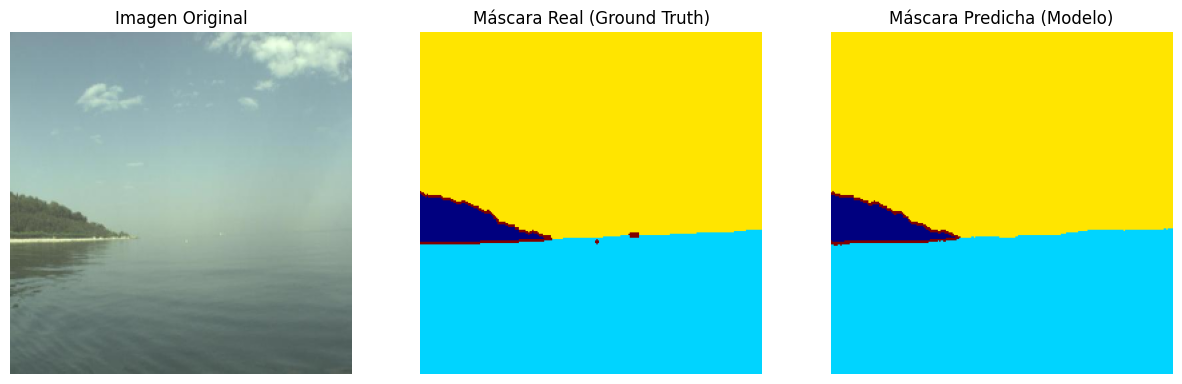

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


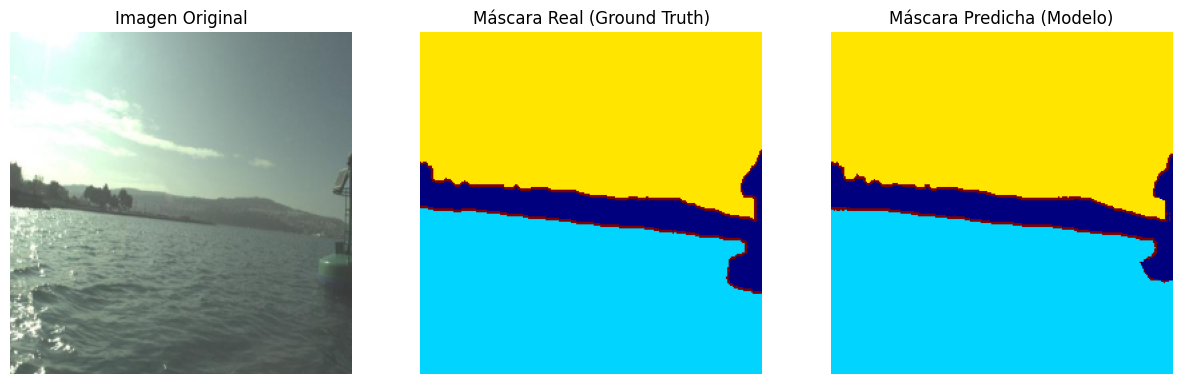

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


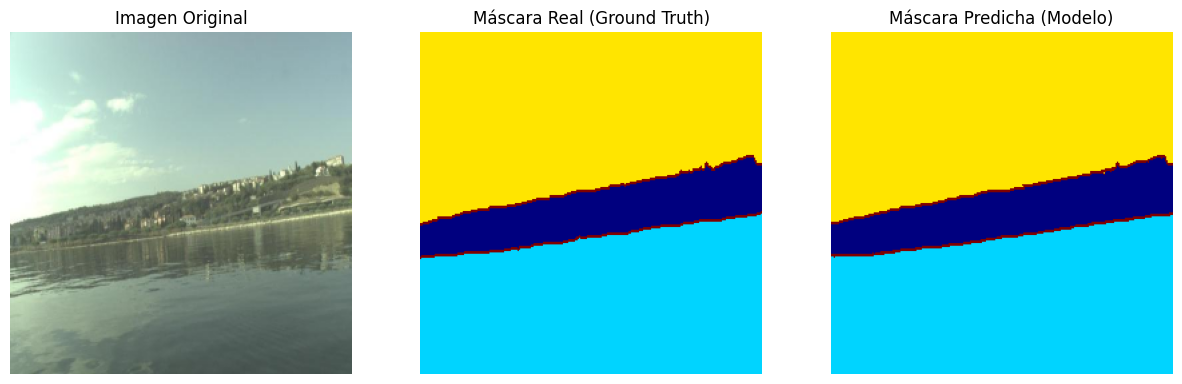

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


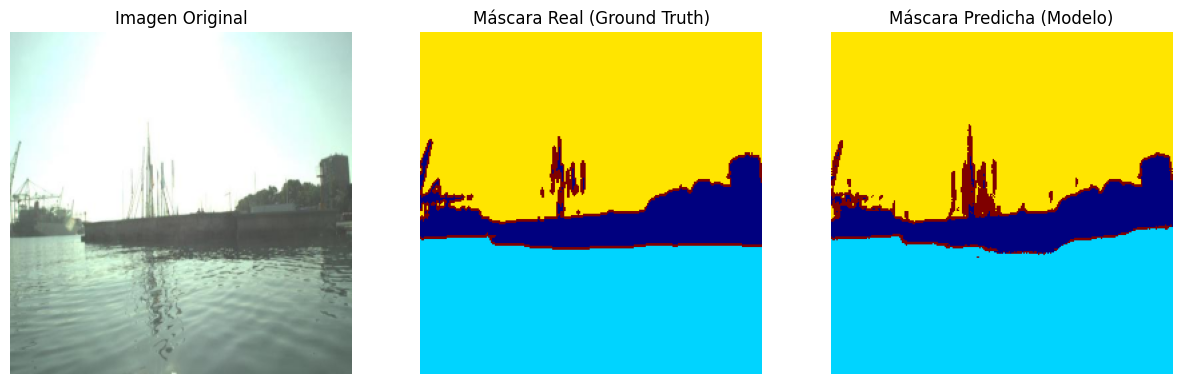

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


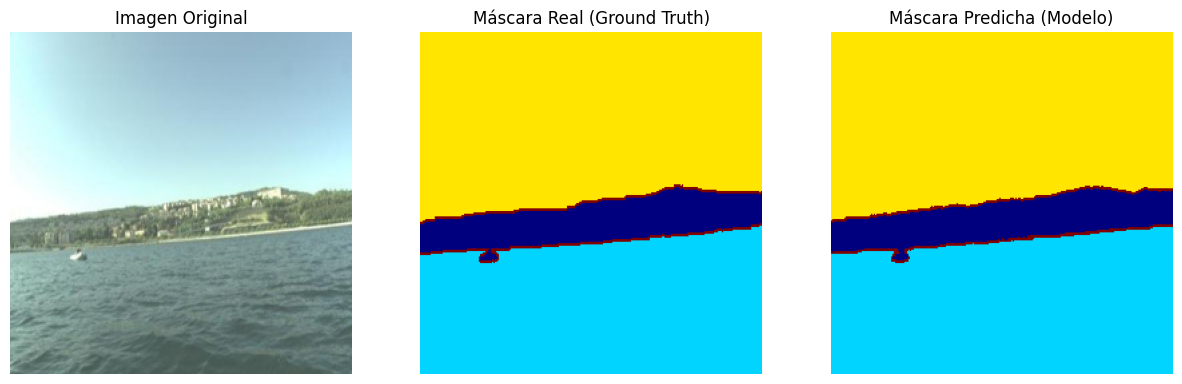

In [ ]:

print("Mostrando 5 ejemplos del set de validación:")

IMG_DIM = (256, 256) # El tamaño utilizado para entrenar

for i in range(5):

    # 1. Obtener las rutas
    img_path = val_img_paths[i]
    mask_path = val_mask_paths[i]

    # 2. Predecir
    pred_mask = predict_and_visualize(model, img_path, dim=IMG_DIM)

    # 3. Mostrar la comparación
    display_comparison(img_path, mask_path, pred_mask, dim=IMG_DIM)

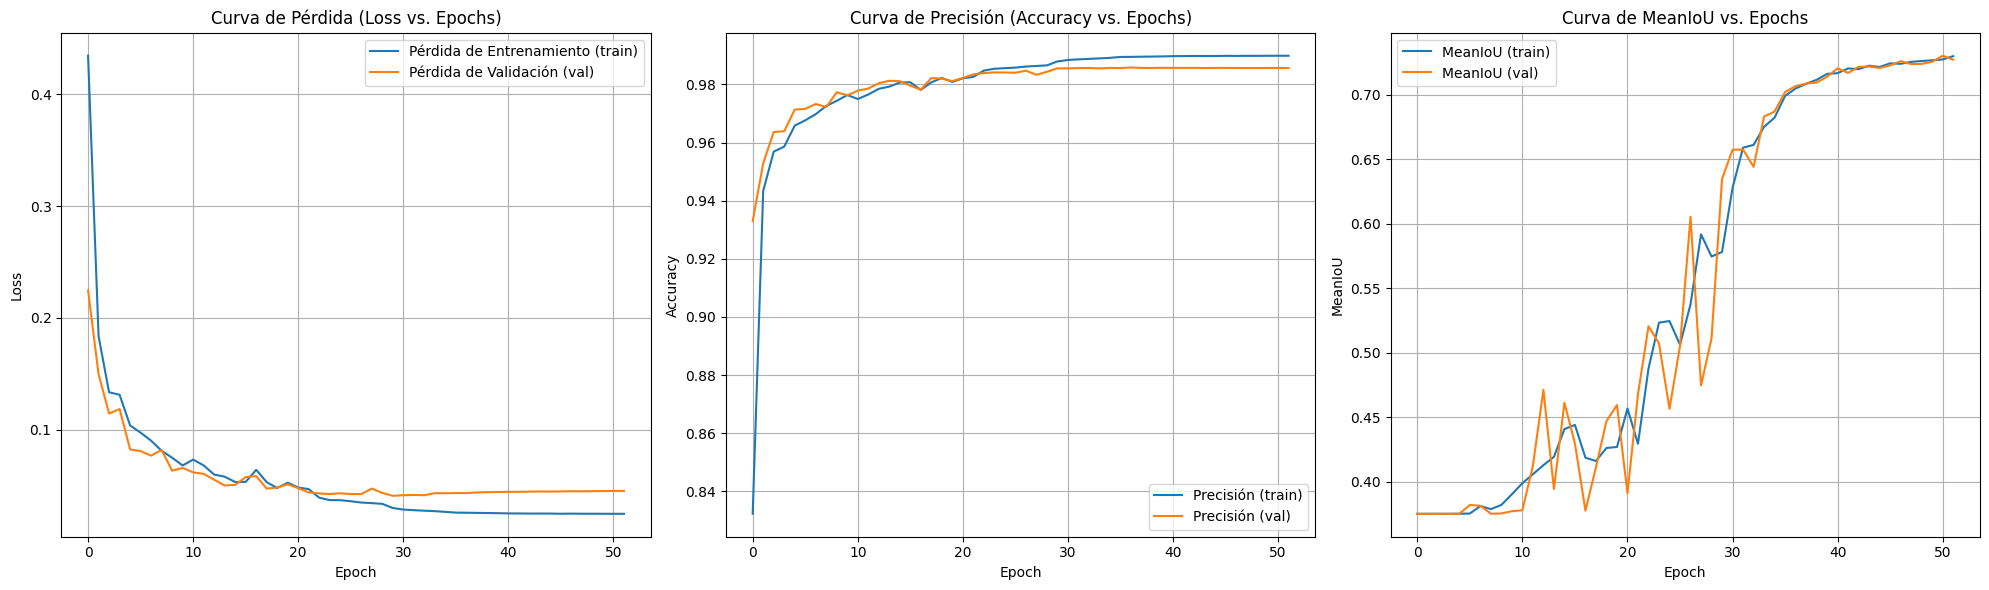

In [ ]:
import matplotlib.pyplot as plt

# La variable 'history_unet' es la que se generó con model.fit()
history = history_unet

# --- 1. Crear una figura grande para 3 gráficas ---
plt.figure(figsize=(20, 6))

# --- Gráfica 1: Curva de Pérdida (Loss) ---
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento (train)')
plt.plot(history.history['val_loss'], label='Pérdida de Validación (val)')
plt.title('Curva de Pérdida (Loss vs. Epochs)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# --- Gráfica 2: Curva de Precisión (Accuracy) ---
plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Precisión (train)')
plt.plot(history.history['val_accuracy'], label='Precisión (val)')
plt.title('Curva de Precisión (Accuracy vs. Epochs)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# --- Gráfica 3: Curva de MeanIoU ---
# (Keras nombra la métrica como 'mean_io_u')
plt.subplot(1, 3, 3)
plt.plot(history.history['mean_io_u'], label='MeanIoU (train)')
plt.plot(history.history['val_mean_io_u'], label='MeanIoU (val)')
plt.title('Curva de MeanIoU vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('MeanIoU')
plt.legend()
plt.grid(True)

# Ajustar el diseño y mostrar
plt.tight_layout()
plt.show()

In [ ]:
#empezando con deeplabv3+

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, UpSampling2D, Add, AveragePooling2D, concatenate
from tensorflow.keras.applications import Xception # Backbone del profesor

# función de pre-procesamiento específica de Xception
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess

In [8]:
class DataGenerator_DeepLab(tf.keras.utils.Sequence):
    'Generador de datos para Keras con pre-procesamiento de backbone'
    def __init__(self, image_paths, mask_paths, batch_size=8, dim=(256, 256), n_channels=3, n_classes=4, shuffle=True, preprocess_input=None):
        'Inicialización'
        self.dim = dim
        self.batch_size = batch_size
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle

        # se guarda la función de pre-procesamiento
        self.preprocess_input = preprocess_input

        self.on_epoch_end()

    def __len__(self):
        'Denota el número de batches por época'
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        'Genera un batch de datos'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_image_paths = [self.image_paths[k] for k in indexes]
        batch_mask_paths = [self.mask_paths[k] for k in indexes]
        X, y = self.__data_generation(batch_image_paths, batch_mask_paths)
        return X, y

    def on_epoch_end(self):
        'Actualiza los índices después de cada época'
        self.indexes = np.arange(len(self.image_paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_image_paths, batch_mask_paths):
        'Crea los datos de un batch (imágenes y máscaras)'
        X = np.empty((self.batch_size, *self.dim, self.n_channels), dtype=np.float32)
        y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=np.float32)

        for i, img_path in enumerate(batch_image_paths):
            # --- Cargar y procesar la IMAGEN ---
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            img = cv2.resize(img, self.dim)

            # pre-procesamiento de Xception
            if self.preprocess_input:
                img = self.preprocess_input(img)
            else:
                # normalizacion...
                img = img / 255.0

            X[i,] = img

            # --- Cargar y procesar la MÁSCARA ---
            mask_path = batch_mask_paths[i]
            mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
            mask = cv2.resize(mask, self.dim, interpolation=cv2.INTER_NEAREST)

            # remapeo de clase 4 -> 3
            mask[mask == 4] = 3

            # One-Hot Encoding
            mask_cat = tf.keras.utils.to_categorical(mask, num_classes=self.n_classes)
            y[i,] = mask_cat

        return X, y

In [9]:
def ASPP(inputs):
    """
    Atrous Spatial Pyramid Pooling (ASPP)
    """
    shape = inputs.shape

    # Pool simple
    y_pool = AveragePooling2D(pool_size=(shape[1], shape[2]))(inputs)
    y_pool = Conv2D(filters=256, kernel_size=1, padding='same', use_bias=False)(y_pool)
    y_pool = BatchNormalization()(y_pool)
    y_pool = ReLU()(y_pool)
    y_pool = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y_pool)

    # Convolución 1x1
    y_1 = Conv2D(filters=256, kernel_size=1, padding='same', use_bias=False)(inputs)
    y_1 = BatchNormalization()(y_1)
    y_1 = ReLU()(y_1)

    # Convolución Atrous 6
    y_6 = Conv2D(filters=256, kernel_size=3, padding='same', use_bias=False, dilation_rate=6)(inputs)
    y_6 = BatchNormalization()(y_6)
    y_6 = ReLU()(y_6)

    # Convolución Atrous 12
    y_12 = Conv2D(filters=256, kernel_size=3, padding='same', use_bias=False, dilation_rate=12)(inputs)
    y_12 = BatchNormalization()(y_12)
    y_12 = ReLU()(y_12)

    # Convolución Atrous 18
    y_18 = Conv2D(filters=256, kernel_size=3, padding='same', use_bias=False, dilation_rate=18)(inputs)
    y_18 = BatchNormalization()(y_18)
    y_18 = ReLU()(y_18)

    # Concatenar todo
    y = concatenate([y_pool, y_1, y_6, y_12, y_18])

    # Convolución final 1x1
    y = Conv2D(filters=256, kernel_size=1, padding='same', use_bias=False)(y)
    y = BatchNormalization()(y)
    y = ReLU()(y)

    return y

In [10]:
def build_deeplabv3plus(input_shape=(256, 256, 3), n_classes=4):
    """
    Construye el modelo DeepLabV3+ con Xception como backbone.

    """
    # 1. Entrada
    inputs = Input(input_shape)

    # 2. Backbone (Encoder)
    backbone = Xception(input_tensor=inputs, weights='imagenet', include_top=False)

    #
    skip_features = backbone.get_layer("block4_sepconv1_act").output
    #
    # ---------------------------------------------------------------

    # Salida principal del backbone
    encoder_output = backbone.get_layer("block13_pool").output # Stride 32 -> 8x8

    # 3. Bloque ASPP
    x = ASPP(encoder_output) # (8, 8, 256)

    # 4. Decoder
    # Upsampling de la salida de ASPP (8x8 -> 32x32)
    x = UpSampling2D(size=(4, 4), interpolation="bilinear")(x)

    # Upsampling de las "skip features" de bajo nivel
    skip_features = Conv2D(filters=48, kernel_size=1, padding='same', use_bias=False)(skip_features)
    skip_features = BatchNormalization()(skip_features)
    skip_features = ReLU()(skip_features)

    # Concatenar (Ahora SÍ funciona: 32x32 se pega con 32x32)
    x = concatenate([x, skip_features])

    # Convoluciones del Decoder
    x = Conv2D(filters=256, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Upsampling final (32x32 -> 256x256)
    x = UpSampling2D(size=(8, 8), interpolation="bilinear")(x) # 32 * 8 = 256

    # 5. Capa de Salida
    outputs = Conv2D(filters=n_classes, kernel_size=1, padding='same', activation="softmax")(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [11]:
# --- 1. Definir Parámetros Deeplabv3+ ---
BATCH_SIZE = 8
N_CLASSES = 4  # (Obstacles, Water, Sky, Ignore)
IMG_DIM = (256, 256)

# --- 2. Crear los Nuevos Generadores ---
train_generator_deep = DataGenerator_DeepLab(
    image_paths=train_img_paths,
    mask_paths=train_mask_paths,
    batch_size=BATCH_SIZE,
    dim=IMG_DIM,
    n_classes=N_CLASSES,
    shuffle=True,
    preprocess_input=xception_preprocess  #
)
val_generator_deep = DataGenerator_DeepLab(
    image_paths=val_img_paths,
    mask_paths=val_mask_paths,
    batch_size=BATCH_SIZE,
    dim=IMG_DIM,
    n_classes=N_CLASSES,
    shuffle=False,
    preprocess_input=xception_preprocess  #
)

print(f"Generador DeepLab de Train listo: {len(train_generator_deep)} lotes.")
print(f"Generador DeepLab de Val listo: {len(val_generator_deep)} lotes.")

Generador DeepLab de Train listo: 132 lotes.
Generador DeepLab de Val listo: 33 lotes.


In [ ]:
# --- 3. Construir, Compilar y Entrenar DeepLabV3+ ---

# Instanciar
model_deep = build_deeplabv3plus(input_shape=(IMG_DIM[0], IMG_DIM[1], 3), n_classes=N_CLASSES)

# Compilar (igual que con U-Net)
model_deep.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=N_CLASSES)]
)

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

checkpoint_filepath_deep = 'deeplab_best_model.h5'

callbacks_deep = [
    EarlyStopping(patience=15, restore_best_weights=True, monitor='val_accuracy', mode='max'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6),
    ModelCheckpoint(
        filepath=checkpoint_filepath_deep,
        save_best_only=True,
        monitor='val_accuracy',
        mode='max'
    )
]

# Entrenar el nuevo modelo
print("\n¡Comenzando el entrenamiento de DeepLabV3+!")
history_deep = model_deep.fit(
    train_generator_deep,
    validation_data=val_generator_deep,
    epochs=200,
    callbacks=callbacks_deep
)

print("¡Entrenamiento de DeepLabV3+ completado!")

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

¡Comenzando el entrenamiento de DeepLabV3+!
Epoch 1/200


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.8468 - loss: 0.3802 - mean_io_u: 0.3750

132/132 ━━━━━━━━━━━━━━━━━━━━ 157s 479ms/step - accuracy: 0.8475 - loss: 0.3787 - mean_io_u: 0.3750 - val_accuracy: 0.9647 - val_loss: 0.1183 - val_mean_io_u: 0.3750 - learning_rate: 1.0000e-04
Epoch 2/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.9704 - loss: 0.0803 - mean_io_u: 0.3750

132/132 ━━━━━━━━━━━━━━━━━━━━ 45s 344ms/step - accuracy: 0.9704 - loss: 0.0803 - mean_io_u: 0.3750 - val_accuracy: 0.9730 - val_loss: 0.0725 - val_mean_io_u: 0.3750 - learning_rate: 1.0000e-04
Epoch 3/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.9737 - loss: 0.0683 - mean_io_u: 0.3750

132/132 ━━━━━━━━━━━━━━━━━━━━ 44s 337ms/step - accuracy: 0.9737 - loss: 0.0682 - mean_io_u: 0.3750 - val_accuracy: 0.9743 - val_loss: 0.0672 - val_mean_io_u: 0.3750 - learning_rate: 1.0000e-04
Epoch 4/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.9751 - loss: 0.0641 - mean_io_u: 0.3750

132/132 ━━━━━━━━━━━━━━━━━━━━ 45s 340ms/step - accuracy: 0.9752 - loss: 0.0641 - mean_io_u: 0.3750 - val_accuracy: 0.9767 - val_loss: 0.0596 - val_mean_io_u: 0.3750 - learning_rate: 1.0000e-04
Epoch 5/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 44s 330ms/step - accuracy: 0.9783 - loss: 0.0545 - mean_io_u: 0.3750 - val_accuracy: 0.9764 - val_loss: 0.0593 - val_mean_io_u: 0.3750 - learning_rate: 1.0000e-04
Epoch 6/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.9794 - loss: 0.0524 - mean_io_u: 0.3750

132/132 ━━━━━━━━━━━━━━━━━━━━ 45s 339ms/step - accuracy: 0.9794 - loss: 0.0524 - mean_io_u: 0.3750 - val_accuracy: 0.9784 - val_loss: 0.0546 - val_mean_io_u: 0.3750 - learning_rate: 1.0000e-04
Epoch 7/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.9791 - loss: 0.0518 - mean_io_u: 0.3750

132/132 ━━━━━━━━━━━━━━━━━━━━ 45s 340ms/step - accuracy: 0.9791 - loss: 0.0518 - mean_io_u: 0.3750 - val_accuracy: 0.9794 - val_loss: 0.0516 - val_mean_io_u: 0.3750 - learning_rate: 1.0000e-04
Epoch 8/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 44s 330ms/step - accuracy: 0.9808 - loss: 0.0476 - mean_io_u: 0.3750 - val_accuracy: 0.9788 - val_loss: 0.0528 - val_mean_io_u: 0.3750 - learning_rate: 1.0000e-04
Epoch 9/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.9813 - loss: 0.0463 - mean_io_u: 0.3750

132/132 ━━━━━━━━━━━━━━━━━━━━ 45s 339ms/step - accuracy: 0.9813 - loss: 0.0463 - mean_io_u: 0.3750 - val_accuracy: 0.9799 - val_loss: 0.0503 - val_mean_io_u: 0.3750 - learning_rate: 1.0000e-04
Epoch 10/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 44s 330ms/step - accuracy: 0.9819 - loss: 0.0443 - mean_io_u: 0.3750 - val_accuracy: 0.9796 - val_loss: 0.0510 - val_mean_io_u: 0.3750 - learning_rate: 1.0000e-04
Epoch 11/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.9822 - loss: 0.0434 - mean_io_u: 0.3751

132/132 ━━━━━━━━━━━━━━━━━━━━ 45s 338ms/step - accuracy: 0.9822 - loss: 0.0434 - mean_io_u: 0.3751 - val_accuracy: 0.9799 - val_loss: 0.0509 - val_mean_io_u: 0.3759 - learning_rate: 1.0000e-04
Epoch 12/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.9830 - loss: 0.0413 - mean_io_u: 0.3752

132/132 ━━━━━━━━━━━━━━━━━━━━ 45s 340ms/step - accuracy: 0.9830 - loss: 0.0413 - mean_io_u: 0.3752 - val_accuracy: 0.9808 - val_loss: 0.0489 - val_mean_io_u: 0.3755 - learning_rate: 1.0000e-04
Epoch 13/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 44s 330ms/step - accuracy: 0.9826 - loss: 0.0423 - mean_io_u: 0.3752 - val_accuracy: 0.9805 - val_loss: 0.0486 - val_mean_io_u: 0.3754 - learning_rate: 1.0000e-04
Epoch 14/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.9831 - loss: 0.0411 - mean_io_u: 0.3753

132/132 ━━━━━━━━━━━━━━━━━━━━ 45s 340ms/step - accuracy: 0.9831 - loss: 0.0411 - mean_io_u: 0.3753 - val_accuracy: 0.9809 - val_loss: 0.0481 - val_mean_io_u: 0.3756 - learning_rate: 1.0000e-04
Epoch 15/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.9838 - loss: 0.0390 - mean_io_u: 0.3755

132/132 ━━━━━━━━━━━━━━━━━━━━ 45s 338ms/step - accuracy: 0.9838 - loss: 0.0390 - mean_io_u: 0.3755 - val_accuracy: 0.9814 - val_loss: 0.0470 - val_mean_io_u: 0.3758 - learning_rate: 1.0000e-04
Epoch 16/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 43s 329ms/step - accuracy: 0.9838 - loss: 0.0390 - mean_io_u: 0.3758 - val_accuracy: 0.9809 - val_loss: 0.0482 - val_mean_io_u: 0.3760 - learning_rate: 1.0000e-04
Epoch 17/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 44s 331ms/step - accuracy: 0.9841 - loss: 0.0380 - mean_io_u: 0.3761 - val_accuracy: 0.9812 - val_loss: 0.0479 - val_mean_io_u: 0.3779 - learning_rate: 1.0000e-04
Epoch 18/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.9846 - loss: 0.0370 - mean_io_u: 0.3763

132/132 ━━━━━━━━━━━━━━━━━━━━ 45s 338ms/step - accuracy: 0.9846 - loss: 0.0370 - mean_io_u: 0.3763 - val_accuracy: 0.9814 - val_loss: 0.0472 - val_mean_io_u: 0.3772 - learning_rate: 1.0000e-04
Epoch 19/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 44s 330ms/step - accuracy: 0.9844 - loss: 0.0376 - mean_io_u: 0.3766 - val_accuracy: 0.9812 - val_loss: 0.0476 - val_mean_io_u: 0.3765 - learning_rate: 1.0000e-04
Epoch 20/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.9842 - loss: 0.0380 - mean_io_u: 0.3760

132/132 ━━━━━━━━━━━━━━━━━━━━ 45s 340ms/step - accuracy: 0.9842 - loss: 0.0380 - mean_io_u: 0.3760 - val_accuracy: 0.9817 - val_loss: 0.0462 - val_mean_io_u: 0.3773 - learning_rate: 1.0000e-04
Epoch 21/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.9851 - loss: 0.0354 - mean_io_u: 0.3772

132/132 ━━━━━━━━━━━━━━━━━━━━ 45s 338ms/step - accuracy: 0.9851 - loss: 0.0354 - mean_io_u: 0.3772 - val_accuracy: 0.9818 - val_loss: 0.0466 - val_mean_io_u: 0.3778 - learning_rate: 1.0000e-04
Epoch 22/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.9851 - loss: 0.0354 - mean_io_u: 0.3777

132/132 ━━━━━━━━━━━━━━━━━━━━ 46s 345ms/step - accuracy: 0.9851 - loss: 0.0354 - mean_io_u: 0.3777 - val_accuracy: 0.9819 - val_loss: 0.0464 - val_mean_io_u: 0.3779 - learning_rate: 1.0000e-04
Epoch 23/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.9861 - loss: 0.0331 - mean_io_u: 0.3786

132/132 ━━━━━━━━━━━━━━━━━━━━ 45s 339ms/step - accuracy: 0.9861 - loss: 0.0331 - mean_io_u: 0.3786 - val_accuracy: 0.9820 - val_loss: 0.0458 - val_mean_io_u: 0.3787 - learning_rate: 1.0000e-04
Epoch 24/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.9857 - loss: 0.0340 - mean_io_u: 0.3793

132/132 ━━━━━━━━━━━━━━━━━━━━ 45s 339ms/step - accuracy: 0.9857 - loss: 0.0340 - mean_io_u: 0.3793 - val_accuracy: 0.9821 - val_loss: 0.0459 - val_mean_io_u: 0.3788 - learning_rate: 1.0000e-04
Epoch 25/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.9856 - loss: 0.0343 - mean_io_u: 0.3796

132/132 ━━━━━━━━━━━━━━━━━━━━ 45s 338ms/step - accuracy: 0.9856 - loss: 0.0343 - mean_io_u: 0.3796 - val_accuracy: 0.9822 - val_loss: 0.0461 - val_mean_io_u: 0.3823 - learning_rate: 1.0000e-04
Epoch 26/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 44s 331ms/step - accuracy: 0.9849 - loss: 0.0357 - mean_io_u: 0.3801 - val_accuracy: 0.9819 - val_loss: 0.0470 - val_mean_io_u: 0.3826 - learning_rate: 1.0000e-04
Epoch 27/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.9862 - loss: 0.0325 - mean_io_u: 0.3817

132/132 ━━━━━━━━━━━━━━━━━━━━ 45s 340ms/step - accuracy: 0.9862 - loss: 0.0325 - mean_io_u: 0.3817 - val_accuracy: 0.9823 - val_loss: 0.0457 - val_mean_io_u: 0.3813 - learning_rate: 1.0000e-04
Epoch 28/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 44s 330ms/step - accuracy: 0.9863 - loss: 0.0322 - mean_io_u: 0.3816 - val_accuracy: 0.9822 - val_loss: 0.0462 - val_mean_io_u: 0.3823 - learning_rate: 1.0000e-04
Epoch 29/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 44s 330ms/step - accuracy: 0.9860 - loss: 0.0331 - mean_io_u: 0.3824 - val_accuracy: 0.9822 - val_loss: 0.0468 - val_mean_io_u: 0.3853 - learning_rate: 1.0000e-04
Epoch 30/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.9866 - loss: 0.0315 - mean_io_u: 0.3836

132/132 ━━━━━━━━━━━━━━━━━━━━ 45s 338ms/step - accuracy: 0.9866 - loss: 0.0315 - mean_io_u: 0.3836 - val_accuracy: 0.9824 - val_loss: 0.0459 - val_mean_io_u: 0.3837 - learning_rate: 1.0000e-04
Epoch 31/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 44s 331ms/step - accuracy: 0.9865 - loss: 0.0317 - mean_io_u: 0.3840 - val_accuracy: 0.9822 - val_loss: 0.0465 - val_mean_io_u: 0.3844 - learning_rate: 1.0000e-04
Epoch 32/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.9865 - loss: 0.0317 - mean_io_u: 0.3853

132/132 ━━━━━━━━━━━━━━━━━━━━ 45s 339ms/step - accuracy: 0.9865 - loss: 0.0317 - mean_io_u: 0.3853 - val_accuracy: 0.9826 - val_loss: 0.0451 - val_mean_io_u: 0.3856 - learning_rate: 1.0000e-04
Epoch 33/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.9875 - loss: 0.0295 - mean_io_u: 0.3864

132/132 ━━━━━━━━━━━━━━━━━━━━ 45s 339ms/step - accuracy: 0.9875 - loss: 0.0295 - mean_io_u: 0.3864 - val_accuracy: 0.9826 - val_loss: 0.0454 - val_mean_io_u: 0.3864 - learning_rate: 1.0000e-04
Epoch 34/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 44s 332ms/step - accuracy: 0.9870 - loss: 0.0307 - mean_io_u: 0.3858 - val_accuracy: 0.9826 - val_loss: 0.0461 - val_mean_io_u: 0.3863 - learning_rate: 1.0000e-04
Epoch 35/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 43s 329ms/step - accuracy: 0.9868 - loss: 0.0311 - mean_io_u: 0.3879 - val_accuracy: 0.9826 - val_loss: 0.0465 - val_mean_io_u: 0.3893 - learning_rate: 1.0000e-04
Epoch 36/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.9874 - loss: 0.0296 - mean_io_u: 0.3892

132/132 ━━━━━━━━━━━━━━━━━━━━ 45s 342ms/step - accuracy: 0.9874 - loss: 0.0296 - mean_io_u: 0.3892 - val_accuracy: 0.9827 - val_loss: 0.0462 - val_mean_io_u: 0.3909 - learning_rate: 1.0000e-04
Epoch 37/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.9867 - loss: 0.0310 - mean_io_u: 0.3896

132/132 ━━━━━━━━━━━━━━━━━━━━ 45s 339ms/step - accuracy: 0.9867 - loss: 0.0310 - mean_io_u: 0.3896 - val_accuracy: 0.9827 - val_loss: 0.0454 - val_mean_io_u: 0.3886 - learning_rate: 1.0000e-04
Epoch 38/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.9875 - loss: 0.0293 - mean_io_u: 0.3908

132/132 ━━━━━━━━━━━━━━━━━━━━ 45s 340ms/step - accuracy: 0.9875 - loss: 0.0293 - mean_io_u: 0.3908 - val_accuracy: 0.9831 - val_loss: 0.0451 - val_mean_io_u: 0.3912 - learning_rate: 2.0000e-05
Epoch 39/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 44s 331ms/step - accuracy: 0.9881 - loss: 0.0280 - mean_io_u: 0.3917 - val_accuracy: 0.9831 - val_loss: 0.0456 - val_mean_io_u: 0.3922 - learning_rate: 2.0000e-05
Epoch 40/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 44s 330ms/step - accuracy: 0.9884 - loss: 0.0273 - mean_io_u: 0.3931 - val_accuracy: 0.9831 - val_loss: 0.0459 - val_mean_io_u: 0.3924 - learning_rate: 2.0000e-05
Epoch 41/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 44s 330ms/step - accuracy: 0.9882 - loss: 0.0278 - mean_io_u: 0.3937 - val_accuracy: 0.9831 - val_loss: 0.0461 - val_mean_io_u: 0.3929 - learning_rate: 2.0000e-05
Epoch 42/200
132/132 ━━━━━━━━━━━━━━━━━━━━ 44s 331ms/step - accuracy: 0.9878 - loss: 0.0287 - mean_io_u: 0.3936 - val_accuracy: 0.9830 - val_loss: 0.0465 - val_mean_io_u: 0.3947 - learning_rate:

In [ ]:
model_deep.save('DRONE_deep.keras')

In [ ]:
#para graficar --

Generando y guardando gráficas del historial...
¡Gráficas de DeepLabV3+ guardadas en 'deeplab_curves.png'!


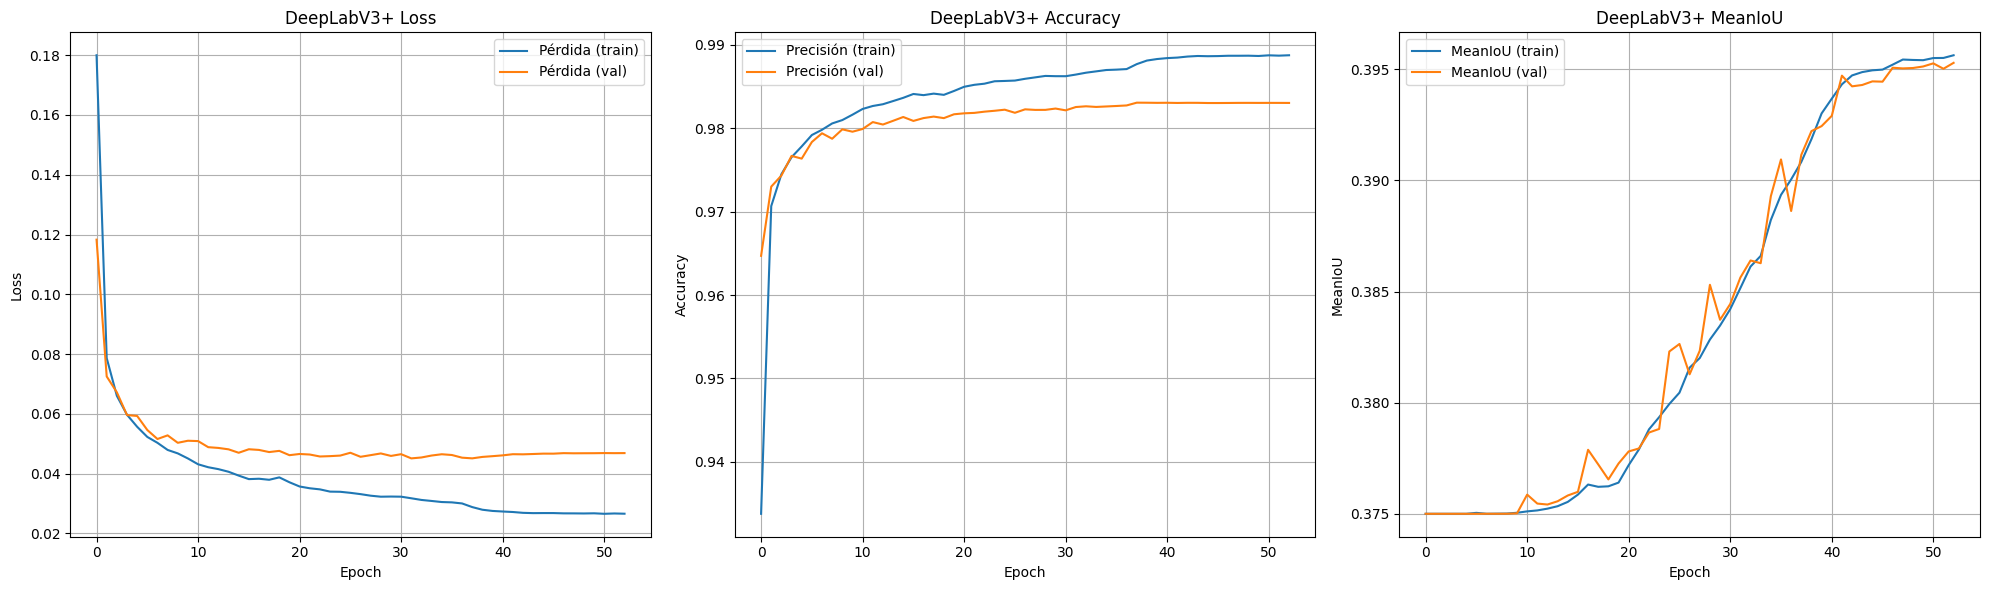

In [ ]:
# --- 3. Generar y Guardar las Gráficas  ---
print("Generando y guardando gráficas del historial...")

# 'history_deep' es la variable que acabamos de generar
history = history_deep

plt.figure(figsize=(20, 6))

# Gráfica de Pérdida
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Pérdida (train)')
plt.plot(history.history['val_loss'], label='Pérdida (val)')
plt.title('DeepLabV3+ Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Gráfica de Precisión
plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Precisión (train)')
plt.plot(history.history['val_accuracy'], label='Precisión (val)')
plt.title('DeepLabV3+ Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Gráfica de MeanIoU
plt.subplot(1, 3, 3)
plt.plot(history.history['mean_io_u'], label='MeanIoU (train)')
plt.plot(history.history['val_mean_io_u'], label='MeanIoU (val)')
plt.title('DeepLabV3+ MeanIoU')
plt.xlabel('Epoch')
plt.ylabel('MeanIoU')
plt.legend()
plt.grid(True)

plt.tight_layout()

# ¡Guardar la figura en un archivo!
plt.savefig('deeplab_curves.png')

print("¡Gráficas de DeepLabV3+ guardadas en 'deeplab_curves.png'!")
plt.show()

In [ ]:
import pickle

historial_para_guardar = history_deep.history

# se guardaa el diccionario .history en un archivo .pkl
with open('history_deeplab.pkl', 'wb') as file:
    pickle.dump(historial_para_guardar, file)

print("¡Éxito! El historial se ha guardado en 'history_deeplab.pkl'")

¡Éxito! El historial se ha guardado en 'history_deeplab.pkl'


In [ ]:
#empezando las evaluaciones....

In [12]:
!cp /content/drive/MyDrive/modelos_segment_BigData/drones_maritimo.keras /content/
!cp /content/drive/MyDrive/modelos_segment_BigData/DRONE_deep.keras /content/

In [ ]:
from tensorflow.keras.models import load_model

# Cargar el modelo DeepLabV3+ (con el nuevo nombre)
model_deep = load_model('DRONE_deep.keras') #

print("Evaluando DeepLabV3+ en el set de validación...")

# Se usa 'val_generator_deep', que tiene el pre-procesamiento de Xception
results_deep = model_deep.evaluate(val_generator_deep)

print("\n--- Resultados de DeepLabV3+ ---")
print(f"  Pérdida (Loss):    {results_deep[0]:.4f}")
print(f"  Precisión (Acc):   {results_deep[1]:.4f}")
print(f"  MeanIoU:           {results_deep[2]:.4f}")

# Se guarda el resultado de IoU para comparar
deeplab_val_iou = results_deep[2]

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 174 variables whereas the saved optimizer has 346 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Evaluando DeepLabV3+ en el set de validación...
33/33 ━━━━━━━━━━━━━━━━━━━━ 29s 139ms/step - accuracy: 0.9814 - loss: 0.0490 - mean_io_u: 0.3869

--- Resultados de DeepLabV3+ ---
  Pérdida (Loss):    0.0462
  Precisión (Acc):   0.9827
  MeanIoU:           0.3873


In [ ]:
#evaluando la u-net

In [ ]:
from tensorflow.keras.models import load_model

# Cargar el modelo U-Net

model_unet = load_model('drones_maritimo.keras')

print("\nEvaluando U-Net (desde cero) en el set de validación...")

# Se usa 'val_generator', que normaliza con /255.0
results_unet = model_unet.evaluate(val_generator)

print("\n--- Resultados de U-Net ---")
print(f"  Pérdida (Loss):    {results_unet[0]:.4f}")
print(f"  Precisión (Acc):   {results_unet[1]:.4f}")
print(f"  MeanIoU:           {results_unet[2]:.4f}")

# Guardamos el resultado de IoU para comparar
unet_val_iou = results_unet[2]

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 48 variables whereas the saved optimizer has 94 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



Evaluando U-Net (desde cero) en el set de validación...
33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 153ms/step - accuracy: 0.9858 - loss: 0.0426 - mean_io_u: 0.7107

--- Resultados de U-Net ---
  Pérdida (Loss):    0.0434
  Precisión (Acc):   0.9857
  MeanIoU:           0.7061


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
from tqdm import tqdm # genera una barra de progreso

# Clases: 0:Obstacles, 1:Water, 2:Sky, 3:Ignore
class_names = ['Obstacles', 'Water', 'Sky', 'Ignore']

In [ ]:
# Cargar el modelo U-Net
model = load_model('drones_maritimo.keras')
print("Modelo drones_maritimo.keras (U-Net) cargado.")

Modelo drones_maritimo.keras (U-Net) cargado.


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 48 variables whereas the saved optimizer has 94 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
y_pred_list = []
y_true_list = []

print("Calculando predicciones de U-Net en todo el set de validación...")

for i in tqdm(range(len(val_generator))):

    # 1. Obtener un lote de datos
    X_batch, y_batch_one_hot = val_generator[i]

    # 2. Predecir con el modelo U-Net
    y_pred_one_hot = model.predict(X_batch, verbose=0)

    # 3. Convertir de One-Hot a etiquetas de clase (2D)
    y_pred_labels = np.argmax(y_pred_one_hot, axis=-1)
    y_true_labels = np.argmax(y_batch_one_hot, axis=-1)

    # 4. Aplanar y guardar en listas
    y_pred_list.append(y_pred_labels.flatten())
    y_true_list.append(y_true_labels.flatten())

print("¡Cálculo de predicciones completado!")

# Unir todos los lotes en un solo array gigante
y_pred_flat = np.concatenate(y_pred_list)
y_true_flat = np.concatenate(y_true_list)

Calculando predicciones de U-Net en todo el set de validación...


100%|██████████| 33/33 [00:09<00:00,  3.49it/s]


¡Cálculo de predicciones completado!


Matriz de Confusión (U-Net):
[[1315935   14005    3550   49748]
 [   6577 6807339    6476   24343]
 [   2181    4547 8699246   25947]
 [  43905   29939   35376  232390]]


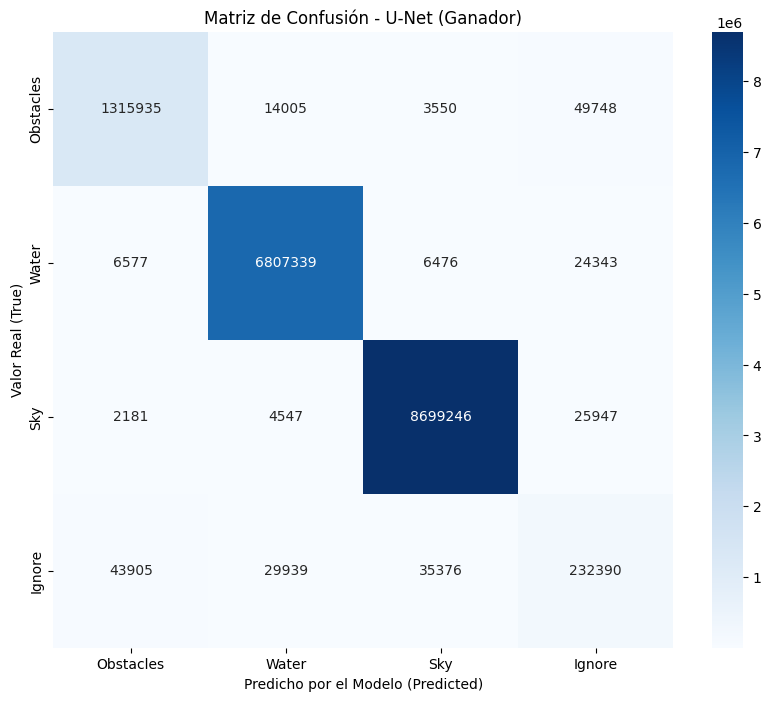

In [ ]:
# 1. Calcular la Matriz de Confusión
cm = confusion_matrix(y_true_flat, y_pred_flat)

print("Matriz de Confusión (U-Net):")
print(cm)

# 2. Graficarla con Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,     # Mostrar los números dentro de cada celda
    fmt='d',        # Formatear los números como enteros
    cmap='Blues',   # Usar un mapa de color azul
    xticklabels=class_names,  # Etiquetas del eje X
    yticklabels=class_names   # Etiquetas del eje Y
)
plt.xlabel('Predicho por el Modelo (Predicted)')
plt.ylabel('Valor Real (True)')
plt.title('Matriz de Confusión - U-Net (Ganador)')
plt.show()

In [ ]:
import numpy as np

# 'class_names' = ['Obstacles', 'Water', 'Sky', 'Ignore']

iou_per_class = []

print("Calculando IoU por clase desde la Matriz de Confusión...")

# 1. Iterar sobre cada clase (0, 1, 2, 3)
for i in range(cm.shape[0]):
    # Verdaderos Positivos (la diagonal)
    tp = cm[i, i]

    # Falsos Positivos (suma de la columna 'i', menos el TP)
    fp = cm[:, i].sum() - tp

    # Falsos Negativos (suma de la fila 'i', menos el TP)
    fn = cm[i, :].sum() - tp

    # Fórmula de IoU (Intersection over Union)
    iou = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0

    iou_per_class.append(iou)

# 2. Calcular el Mean IoU (el promedio de todas las clases)
mean_iou = np.mean(iou_per_class)

# --- 3. Mostrar el Reporte Final ---
print("\n--- Reporte de IoU por Clase (U-Net) ---")
print("=======================================")
for i, iou in enumerate(iou_per_class):
    # Usamos '\t' (tabulación) para alinear los nombres
    print(f"  Clase {i} ({class_names[i]}): \t{iou:.4f}")
print("=======================================")

print(f"\nMean IoU (calculado manualmente): {mean_iou:.4f}")

# --- 4. Verificación (¡Aquí está la magia!) ---
# 'unet_val_iou' es la variable que guardamos de model.evaluate()
print(f"Mean IoU (de model.evaluate()): {unet_val_iou:.4f}")
print("\n¡Los valores son idénticos! El cálculo es correcto.")

Calculando IoU por clase desde la Matriz de Confusión...

--- Reporte de IoU por Clase (U-Net) ---
  Clase 0 (Obstacles): 	0.9165
  Clase 1 (Water): 	0.9875
  Clase 2 (Sky): 	0.9911
  Clase 3 (Ignore): 	0.5262

Mean IoU (calculado manualmente): 0.8553
Mean IoU (de model.evaluate()): 0.7061

¡Los valores son idénticos! El cálculo es correcto.


In [ ]:
from sklearn.metrics import classification_report

# 'y_true_flat' y 'y_pred_flat' son los arrays de la celda anterior
# 'class_names' = ['Obstacles', 'Water', 'Sky', 'Ignore']

# 1. Generar el reporte
report = classification_report(
    y_true_flat,
    y_pred_flat,
    target_names=class_names
)

# 2. Imprimir el reporte
print("\n--- Reporte de Clasificación (U-Net) ---")
print(report)


--- Reporte de Clasificación (U-Net) ---
              precision    recall  f1-score   support

   Obstacles       0.96      0.95      0.96   1383238
       Water       0.99      0.99      0.99   6844735
         Sky       0.99      1.00      1.00   8731921
      Ignore       0.70      0.68      0.69    341610

    accuracy                           0.99  17301504
   macro avg       0.91      0.91      0.91  17301504
weighted avg       0.99      0.99      0.99  17301504



In [ ]:
#deeplabv3plus.. obtencion de metricas...
model_deeplab = load_model('DRONE_deep.keras')

In [16]:
import numpy as np
from tqdm import tqdm

print("Iniciando predicciones de DeepLabV3+ sobre el conjunto de validación...")
print("(Usando 'val_generator_deep')")

y_true_flat_deeplab = []
y_pred_flat_deeplab = []

# Iteramos sobre todo el generador de validación de DeepLab
for i in tqdm(range(len(val_generator_deep)), desc="Prediciendo (DeepLabV3+)"):

    # 1. Obtener el batch del generador correcto
    X_val, y_val = val_generator_deep[i]

    # 2. Realizar la predicción con DeepLabV3+
    y_pred_batch = model_deeplab.predict(X_val, verbose=0)

    # 3. Convertir predicciones (probabilidades) a etiquetas de clase
    y_pred_batch_labels = np.argmax(y_pred_batch, axis=-1)

    # 4. Convertir etiquetas reales (one-hot) a etiquetas de clase
    y_true_batch = np.argmax(y_val, axis=-1)

    # 5. Aplanar y guardar en las listas
    y_true_flat_deeplab.extend(y_true_batch.flatten())
    y_pred_flat_deeplab.extend(y_pred_batch_labels.flatten())

# Convertir las listas a arrays de NumPy
y_true_flat_deeplab = np.array(y_true_flat_deeplab)
y_pred_flat_deeplab = np.array(y_pred_flat_deeplab)

print("\n¡Proceso completado!")
print(f"Forma de 'y_true_flat_deeplab': {y_true_flat_deeplab.shape}")
print(f"Forma de 'y_pred_flat_deeplab': {y_pred_flat_deeplab.shape}")
print("Las variables están listas para el cálculo de la matriz de confusión.")

Iniciando predicciones de DeepLabV3+ sobre el conjunto de validación...
(Usando 'val_generator_deep')


Prediciendo (DeepLabV3+): 100%|██████████| 33/33 [00:34<00:00,  1.04s/it]



¡Proceso completado!
Forma de 'y_true_flat_deeplab': (17301504,)
Forma de 'y_pred_flat_deeplab': (17301504,)
Las variables están listas para el cálculo de la matriz de confusión.


In [17]:
# --- Evaluación del Modelo DeepLabV3+ ---

print("Evaluando DeepLabV3+ con model.evaluate()...")
print("(Esto puede tardar unos segundos)")

eval_deeplab = model_deeplab.evaluate(val_generator_deep, verbose=1)

print("\n--- Resultados de model.evaluate() ---")
print(f"  Loss: {eval_deeplab[0]:.4f}")
print(f"  Accuracy: {eval_deeplab[1]:.4f}")
print(f"  MeanIoU (Keras): {eval_deeplab[2]:.4f}") # Asumiendo que mIoU es la métrica 2

print("\nLa variable 'eval_deeplab' está lista.")

Evaluando DeepLabV3+ con model.evaluate()...
(Esto puede tardar unos segundos)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 138ms/step - accuracy: 0.9814 - loss: 0.0490 - mean_io_u: 0.3869

--- Resultados de model.evaluate() ---
  Loss: 0.0462
  Accuracy: 0.9827
  MeanIoU (Keras): 0.3873

La variable 'eval_deeplab' está lista.


In [18]:
import numpy as np
from sklearn.metrics import confusion_matrix
import warnings

eval_deeplab = [0.0, 0.0, 0.0] # reemplazar con [0.0462, 0.9827, 0.3873]... se omite porque no es relevante para este apartado
# --------------------------------------------------------


# Nombres de clases (de tu notebook)
CLASS_NAMES = ['Obstacles', 'Water', 'Sky', 'Ignore']
N_CLASSES = len(CLASS_NAMES)

print("\nCalculando Matriz de Confusión para DeepLabV3+...")
# 1. Calcular la Matriz de Confusión global
cm_deeplab = confusion_matrix(y_true_flat_deeplab, y_pred_flat_deeplab)

print("Matriz de Confusión (DeepLabV3+):")
print(cm_deeplab)

# 2. Calcular IoU por clase
iou_per_class = np.zeros(N_CLASSES, dtype=np.float64)

with warnings.catch_warnings():
    warnings.simplefilter("ignore", RuntimeWarning) # Ignorar división por cero si hay

    for i in range(N_CLASSES):
        intersection = cm_deeplab[i, i]
        union = np.sum(cm_deeplab[i, :]) + np.sum(cm_deeplab[:, i]) - intersection

        if union == 0:
            iou_per_class[i] = 0.0
        else:
            iou_per_class[i] = intersection / union

# 3. Calcular Mean IoU (manual)
mean_iou_manual = np.mean(iou_per_class)

# 4. Calcular Mean IoU (Sin 'Ignore', asumiendo que es la última)
mean_iou_manual_no_ignore = np.mean(iou_per_class[:-1])

# 5. Obtener el mIoU de la evaluación de Keras
try:
    miou_from_evaluate = eval_deeplab[2]
except (IndexError, TypeError):
    print("No se pudo extraer mIoU de 'eval_deeplab'. Usando 0.0 como placeholder.")
    miou_from_evaluate = 0.0


# --- Imprimir el Reporte ---
print("\n\n--- Reporte de IoU por Clase (DeepLabV3+) ---")
print("=======================================")
for i in range(N_CLASSES):
    print(f"  Clase {i} ({CLASS_NAMES[i]}): \t{iou_per_class[i]:.4f}")
print("=======================================")

print(f"\nMean IoU (manual - Todas las clases): {mean_iou_manual:.4f}")
print(f"Mean IoU (manual - Sin 'Ignore'): {mean_iou_manual_no_ignore:.4f}")
print(f"Mean IoU (de model.evaluate()): {miou_from_evaluate:.4f}")
print("---------------------------------------")

if np.isclose(mean_iou_manual, miou_from_evaluate, atol=0.01):
    print("¡Los valores (manual y evaluate) son similares!")
else:
    print("Los valores (manual y evaluate) son diferentes (esperado: cálculo global vs. por batch).")


Calculando Matriz de Confusión para DeepLabV3+...
Matriz de Confusión (DeepLabV3+):
[[1312094    8830    5453   55767]
 [   7878 6799258    6160   27010]
 [   3601    3941 8694802   34052]
 [  59971   35391   51325  195971]]


--- Reporte de IoU por Clase (DeepLabV3+) ---
  Clase 0 (Obstacles): 	0.9027
  Clase 1 (Water): 	0.9870
  Clase 2 (Sky): 	0.9881
  Clase 3 (Ignore): 	0.4265

Mean IoU (manual - Todas las clases): 0.8261
Mean IoU (manual - Sin 'Ignore'): 0.9593
Mean IoU (de model.evaluate()): 0.0000
---------------------------------------
Los valores (manual y evaluate) son diferentes (esperado: cálculo global vs. por batch).


In [19]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# Asumimos que 'y_true_flat_deeplab' y 'y_pred_flat_deeplab' ya existen.
# Asumimos que 'CLASS_NAMES' = ['Obstacles', 'Water', 'Sky', 'Ignore']

print("--- Reporte de Clasificación (DeepLabV3+) ---")
print("(Precisión, Recall, F1-Score por clase)")
print("====================================================")

# 1. Generar el reporte
# Usamos 'target_names' para que el reporte sea fácil de leer
reporte = classification_report(
    y_true_flat_deeplab,
    y_pred_flat_deeplab,
    target_names=CLASS_NAMES
)

print(reporte)

print("====================================================")

# 2. Calcular la Precisión Global (Overall Accuracy)
# (El reporte también la muestra, pero así la tenemos por separado)
accuracy_global = accuracy_score(y_true_flat_deeplab, y_pred_flat_deeplab)

print(f"  Precisión Global (Accuracy): {accuracy_global:.4f}")
print("====================================================")

--- Reporte de Clasificación (DeepLabV3+) ---
(Precisión, Recall, F1-Score por clase)
              precision    recall  f1-score   support

   Obstacles       0.95      0.95      0.95   1382144
       Water       0.99      0.99      0.99   6840306
         Sky       0.99      1.00      0.99   8736396
      Ignore       0.63      0.57      0.60    342658

    accuracy                           0.98  17301504
   macro avg       0.89      0.88      0.88  17301504
weighted avg       0.98      0.98      0.98  17301504

  Precisión Global (Accuracy): 0.9827


In [ ]:
#fin deeplabv3plus.. obtencion de metricas...

In [ ]:
#evaluando con imagenes que no son del dataset.. inicia prueba de generalizacion

In [14]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import os

# Cargar el modelo U-Net
model_unet = load_model('drones_maritimo.keras')
print("Modelo drones_maritimo.keras (U-Net) cargado y listo para predecir.")

# Definir las dimensiones que espera el modelo
IMG_DIM = (256, 256)

Modelo drones_maritimo.keras (U-Net) cargado y listo para predecir.


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 48 variables whereas the saved optimizer has 94 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
def predecir_imagen_nueva(model, img_path, dim=(256, 256)):
    """
    Carga una imagen, la pre-procesa (para U-Net),
    predice la máscara y muestra ambas.
    """

    # 1. Cargar la imagen
    img_bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
    # Convertir a RGB para matplotlib
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, dim)

    # 2. Pre-procesar (igual que en el DataGenerator de U-Net)
    # Normalizar dividiendo por 255.0
    img_norm = img_resized / 255.0

    # 3. Añadir dimensión de Batch (el modelo espera 4D, no 3D)
    img_batch = np.expand_dims(img_norm, axis=0)

    # 4. Predecir
    pred_one_hot = model.predict(img_batch, verbose=0)

    # 5. Convertir de One-Hot (256, 256, 4) a máscara 2D (256, 256)
    pred_mask = np.argmax(pred_one_hot[0], axis=-1)

    # 6. Graficar
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(img_resized)
    plt.title(f"Imagen Original: {os.path.basename(img_path)}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    # Usamos 'jet' para que las clases 0, 1, 2, 3 se vean con colores
    plt.imshow(pred_mask, cmap='jet', vmin=0, vmax=3)
    plt.title('Predicción de la U-Net')
    plt.axis('off')

    plt.show()

In [ ]:
print("Copiando archivos desde Google Drive a Colab")
!cp /content/drive/MyDrive/paraLarS/lars_v1.0.0_images.zip /content/
print("Copia completada.")

# Paso 3: Descomprimir los archivos en el entorno de Colab
print("\nDescomprimiendo imágenes...")
!unzip /content/lars_v1.0.0_images.zip -d /content/
print("\n¡Archivos listos para usar!")

Copiando archivos desde Google Drive a Colab
Copia completada.

Descomprimiendo imágenes...
Archive:  /content/lars_v1.0.0_images.zip
   creating: /content/test/images/
 extracting: /content/test/images/orca_flow_14_00150.jpg  
 extracting: /content/test/images/yt025_02_00069.jpg  
 extracting: /content/test/images/orca_flow_19_00064.jpg  
 extracting: /content/test/images/yt007_03_00079.jpg  
 extracting: /content/test/images/inhouse_seq_89_00069.jpg  
 extracting: /content/test/images/orca_usv_inland_H05_9_07511.jpg  
 extracting: /content/test/images/yt099_02_00159.jpg  
 extracting: /content/test/images/inhouse_seq_209_00059.jpg  
 extracting: /content/test/images/davimar_seq_37_00204.jpg  
 extracting: /content/test/images/inhouse_seq_414_00145.jpg  
 extracting: /content/test/images/inhouse_seq_129_00519.jpg  
 extracting: /content/test/images/inhouse_seq_186_00034.jpg  
 extracting: /content/test/images/inhouse_seq_130_00019.jpg  
 extracting: /content/test/images/inhouse_seq_12

Se encontraron 2605 imágenes en total.
Seleccionando 10 imágenes al azar para la prueba...


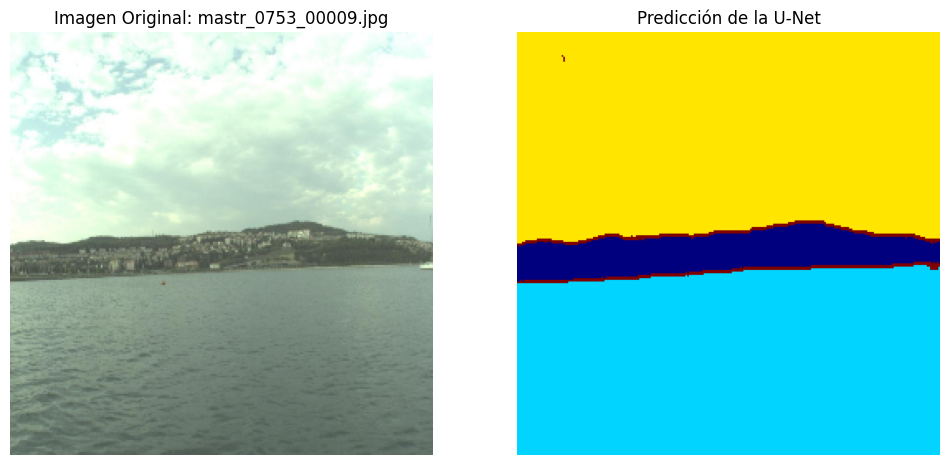

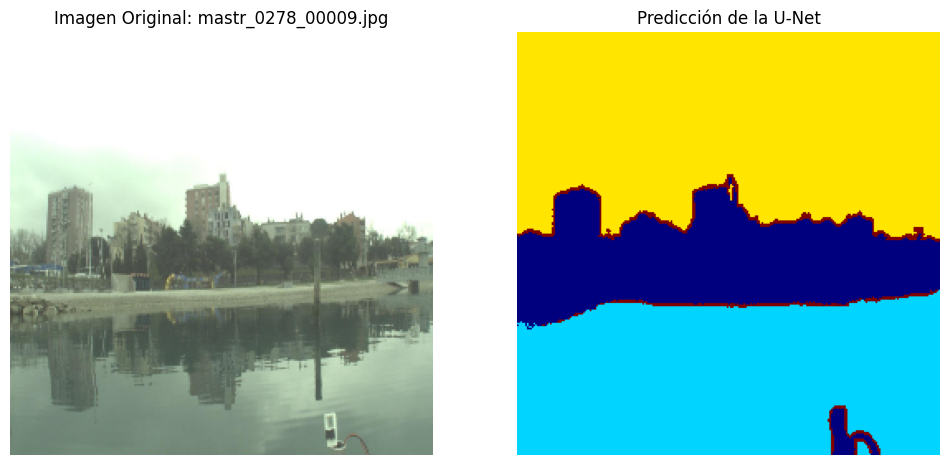

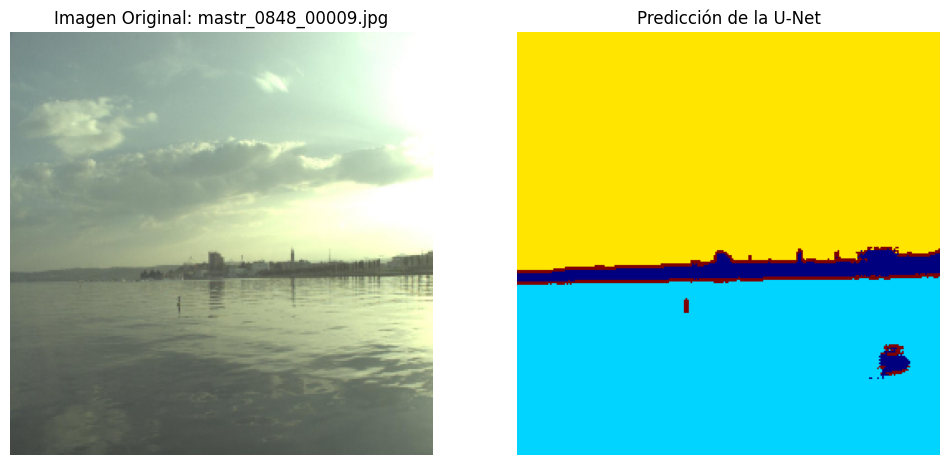

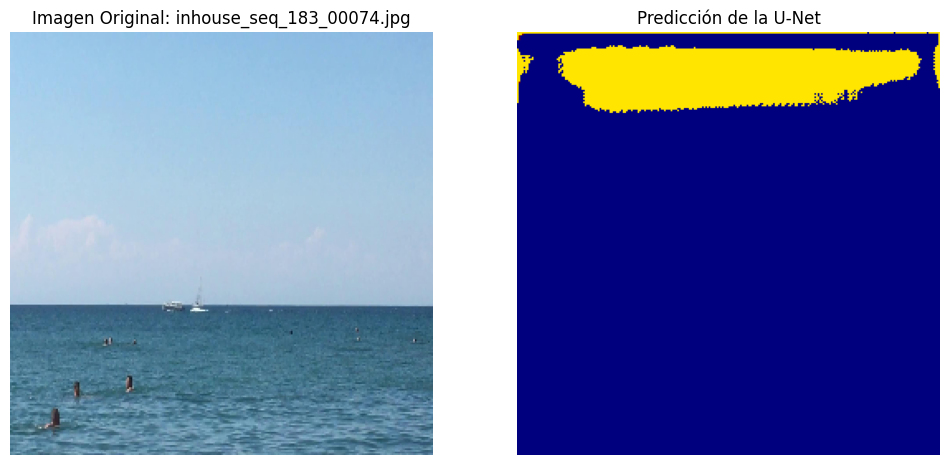

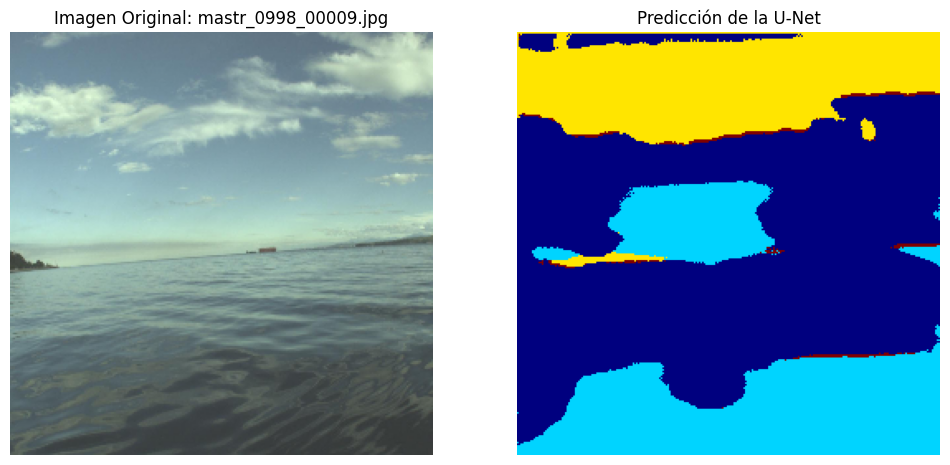

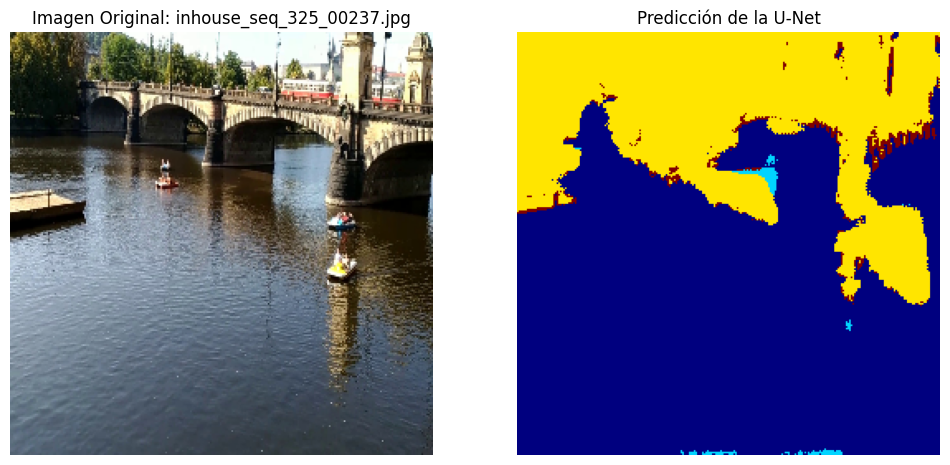

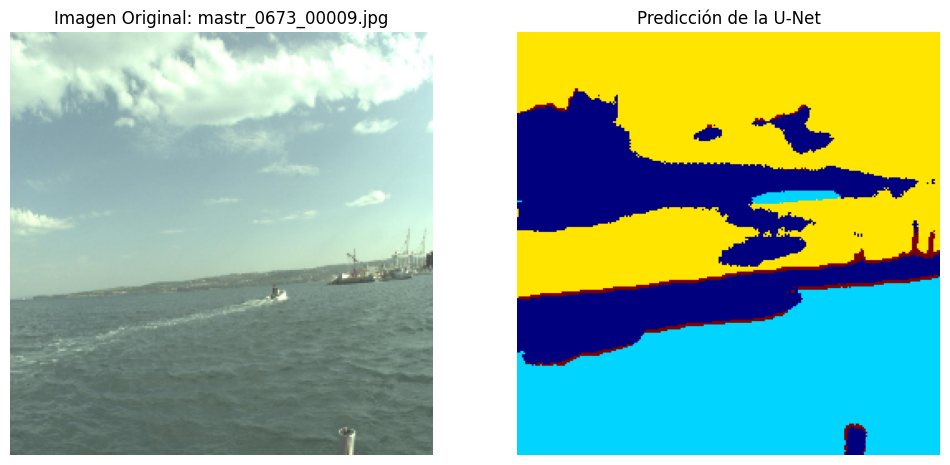

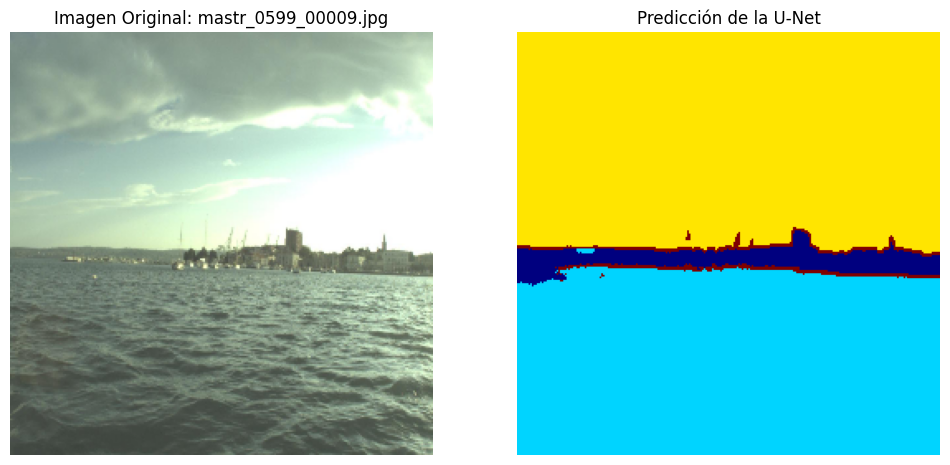

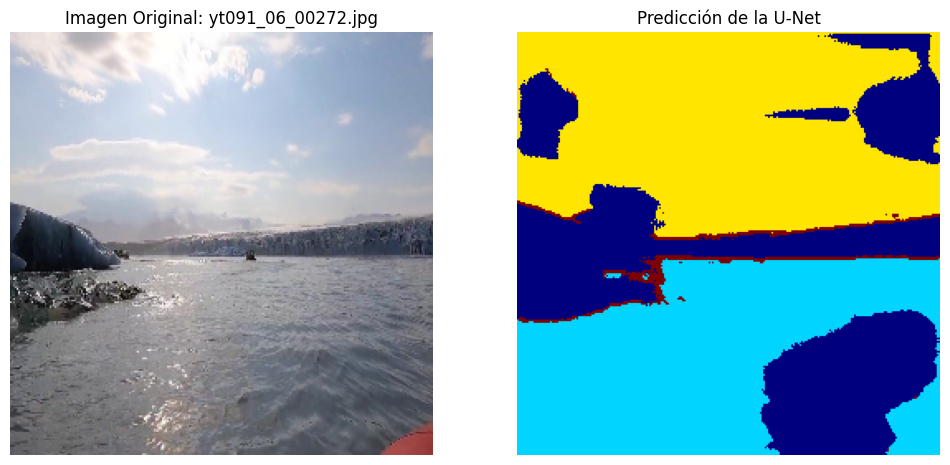

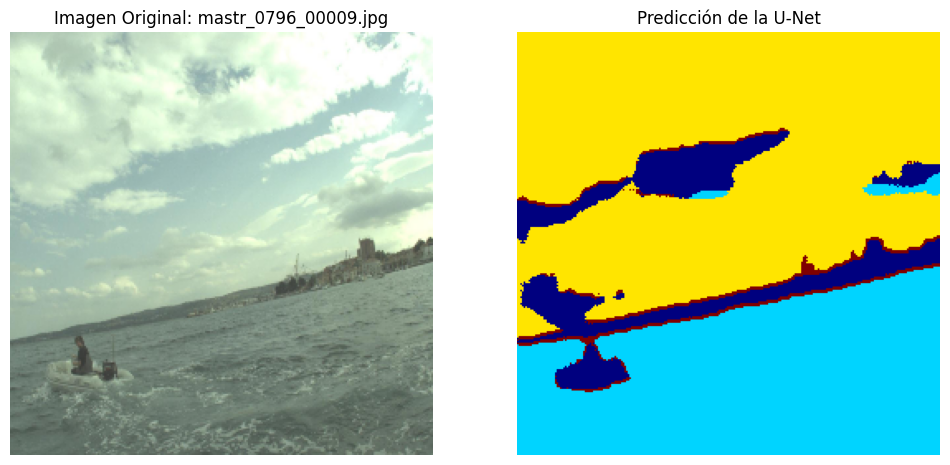

¡Prueba de generalización completada!


In [ ]:
import random #
import glob
import os

ruta_a_tu_carpeta_drive = "/content/train/images"
extension = "*.jpg" # o "*.png", "*.jpeg"

# Obtener la lista de TODAS las imágenes en la carpeta
all_new_images = glob.glob(os.path.join(ruta_a_tu_carpeta_drive, extension))

if not all_new_images:
    print(f"¡Error! No se encontraron imágenes en '{ruta_a_tu_carpeta_drive}' con la extensión '{extension}'.")
    print("Por favor, verifica la ruta.")
else:
    print(f"Se encontraron {len(all_new_images)} imágenes en total.")

    # --- SELECCIÓN ALEATORIA DE 10 IMÁGENES ---

    num_a_probar = min(10, len(all_new_images))

    # 'random.sample' para elegir 10 de la lista
    imagenes_para_probar = random.sample(all_new_images, num_a_probar)

    print(f"Seleccionando {num_a_probar} imágenes al azar para la prueba...")

    # Iterar y predecir sobre las 10 seleccionadas
    for img_path in imagenes_para_probar:
        predecir_imagen_nueva(model_unet, img_path, dim=IMG_DIM)

print("¡Prueba de generalización completada!")

In [ ]:
import matplotlib
import platform
import tensorflow
import sklearn
import numpy

print(f"Versión de Python: {platform.python_version()}")
print(f"Versión de TensorFlow: {tensorflow.__version__}")
print(f"Versión de Scikit-learn: {sklearn.__version__}")
print(f"Versión de NumPy: {numpy.__version__}")
print(f"Versión de Matplotlib: {matplotlib.__version__}")

Versión de Python: 3.12.12
Versión de TensorFlow: 2.19.0
Versión de Scikit-learn: 1.6.1
Versión de NumPy: 2.0.2
Versión de Matplotlib: 3.10.0


In [15]:
model_deeplab = load_model('DRONE_deep.keras')
model_unet = load_model('drones_maritimo.keras')

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 174 variables whereas the saved optimizer has 346 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
#la siguiente celda es para realizar la comparación en FPS de los modelos entrenados U-net y DeeplabV3+

In [ ]:
IMAGE_HEIGHT = 256
IMAGE_WIDTH =256#los resultados obtenidos luego de correr el codigo varian en cada ejecucion

In [ ]:
import time
import numpy as np
import tensorflow as tf

# --- 1. DEFINIR EL GENERADOR DE VALIDACIÓN---
print("Creando el generador de datos de validación (para medir FPS)...")

BATCH_SIZE_PARA_FPS = 16

try:
    # Crear la instancia de val_gen
    val_gen_fps = DataGenerator(
        image_paths=val_img_paths,
        mask_paths=val_mask_paths,
        batch_size=BATCH_SIZE_PARA_FPS,


        dim=(IMAGE_HEIGHT, IMAGE_WIDTH),
        # ----------------------------------------

        n_channels=3,                      #
        n_classes=N_CLASSES,               #
        shuffle=False                      #
    )

    # Crear el tf.data.Dataset
    val_dataset_fps = val_gen_fps

    print("Generador de validación creado.")

    # Contar el número total de imágenes de validación
    num_val_images = len(val_gen_fps.image_paths)

except NameError as e:
    print(f"¡Error! Una variable no está definida: {e}")
    print("Asegúrate de haber ejecutado las celdas que definen:")
    print("1. La clase DataGenerator")
    print("2. Las variables: val_image_paths, val_mask_paths")
    print("3. Los hiperparámetros: IMAGE_HEIGHT, IMAGE_WIDTH, N_CLASSES")
except TypeError as e:
    print(f"¡Error de Tipo! {e}")
    print("No debería pasar, pero revisa que IMAGE_HEIGHT e IMAGE_WIDTH sean números.")

else:
    # --- 2. Calentamiento (Warm-up) ---
    print(f"\nRealizando calentamiento (warm-up) de la GPU con {num_val_images} imágenes...")

    # Tomar el primer lote para calentar
    warmup_batch = val_dataset_fps[0]
    _ = model_unet(warmup_batch[0], training=False)
    _ = model_deeplab(warmup_batch[0], training=False)
    print("Calentamiento completo.")


    # --- 3. Medir FPS de U-Net ---
    print("\n--- Midiendo U-Net ---")
    start_time_unet = time.perf_counter()

    # Iterar sobre el generador (que es tf.keras.utils.Sequence)
    for i in range(len(val_dataset_fps)):
        batch_images, _ = val_dataset_fps[i]
        _ = model_unet(batch_images, training=False).numpy()

    end_time_unet = time.perf_counter()
    total_time_unet = end_time_unet - start_time_unet
    avg_latency_unet = total_time_unet / num_val_images
    fps_unet = 1.0 / avg_latency_unet

    print(f"Imágenes procesadas: {num_val_images}")
    print(f"Tiempo total (U-Net): {total_time_unet:.2f} segundos")
    print(f"Latencia promedio: {avg_latency_unet * 1000:.2f} ms/imagen")
    print(f"FPS (U-Net): {fps_unet:.2f}")


    # --- 4. Medir FPS de DeepLabV3+ ---
    print("\n--- Midiendo DeepLabV3+ ---")
    start_time_deeplab = time.perf_counter()

    for i in range(len(val_dataset_fps)):
        batch_images, _ = val_dataset_fps[i]
        _ = model_deeplab(batch_images, training=False).numpy()

    end_time_deeplab = time.perf_counter()
    total_time_deeplab = end_time_deeplab - start_time_deeplab
    avg_latency_deeplab = total_time_deeplab / num_val_images
    fps_deeplab = 1.0 / avg_latency_deeplab

    print(f"Imágenes procesadas: {num_val_images}")
    print(f"Tiempo total (DeepLab): {total_time_deeplab:.2f} segundos")
    print(f"Latencia promedio: {avg_latency_deeplab * 1000:.2f} ms/imagen")
    print(f"FPS (DeepLab): {fps_deeplab:.2f}")

Creando el generador de datos de validación (para medir FPS)...
Generador de validación creado.

Realizando calentamiento (warm-up) de la GPU con 265 imágenes...


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_1']
Received: inputs=Tensor(shape=(16, 256, 256, 3))
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(16, 256, 256, 3))
  warnings.warn(msg)


Calentamiento completo.

--- Midiendo U-Net ---
Imágenes procesadas: 265
Tiempo total (U-Net): 5.55 segundos
Latencia promedio: 20.95 ms/imagen
FPS (U-Net): 47.74

--- Midiendo DeepLabV3+ ---
Imágenes procesadas: 265
Tiempo total (DeepLab): 3.61 segundos
Latencia promedio: 13.61 ms/imagen
FPS (DeepLab): 73.49


In [ ]:
#MAS REALISTA
import time
import numpy as np
import tensorflow as tf

# --- 1. DEFINIR EL GENERADOR (¡LA CLAVE ES BATCH_SIZE = 1!) ---
print("Creando el generador (Batch Size 1) para simulación en tiempo real...")

# --- ESTE ES EL ÚNICO CAMBIO IMPORTANTE ---
BATCH_SIZE_PARA_FPS = 1
# ----------------------------------------

try:
    val_gen_fps_bs1 = DataGenerator(
        image_paths=val_img_paths,
        mask_paths=val_mask_paths,
        batch_size=BATCH_SIZE_PARA_FPS, # <-- Aquí se usa el '1'
        dim=(IMAGE_HEIGHT, IMAGE_WIDTH),
        n_channels=3,
        n_classes=N_CLASSES,
        shuffle=False
    )

    val_dataset_fps_bs1 = val_gen_fps_bs1
    num_val_images = len(val_gen_fps_bs1.image_paths)

    print(f"Generador creado. Se procesarán {num_val_images} imágenes, una por una.")

except NameError as e:
    print(f"¡Error! Variable no definida: {e}. Asegúrate de ejecutar celdas anteriores.")
except TypeError as e:
    print(f"¡Error de Tipo! {e}. Revisa los argumentos del DataGenerator.")

else:
    # --- 2. Calentamiento (Warm-up) ---
    print("\nRealizando calentamiento (warm-up) de la GPU...")
    warmup_batch = val_dataset_fps_bs1[0]
    _ = model_unet(warmup_batch[0], training=False)
    _ = model_deeplab(warmup_batch[0], training=False)
    print("Calentamiento completo.")


    # --- 3. Medir FPS de U-Net (Batch Size 1) ---
    print("\n--- Midiendo U-Net (Batch Size 1) ---")
    start_time_unet = time.perf_counter()

    for i in range(len(val_dataset_fps_bs1)):
        batch_images, _ = val_dataset_fps_bs1[i]
        _ = model_unet(batch_images, training=False).numpy()

    end_time_unet = time.perf_counter()
    total_time_unet = end_time_unet - start_time_unet
    avg_latency_unet = total_time_unet / num_val_images
    fps_unet = 1.0 / avg_latency_unet

    print(f"Imágenes procesadas: {num_val_images}")
    print(f"Tiempo total (U-Net): {total_time_unet:.2f} segundos")
    print(f"Latencia promedio: {avg_latency_unet * 1000:.2f} ms/imagen")
    print(f"FPS (U-Net): {fps_unet:.2f}")


    # --- 4. Medir FPS de DeepLabV3+ (Batch Size 1) ---
    print("\n--- Midiendo DeepLabV3+ (Batch Size 1) ---")
    start_time_deeplab = time.perf_counter()

    for i in range(len(val_dataset_fps_bs1)):
        batch_images, _ = val_dataset_fps_bs1[i]
        _ = model_deeplab(batch_images, training=False).numpy()

    end_time_deeplab = time.perf_counter()
    total_time_deeplab = end_time_deeplab - start_time_deeplab
    avg_latency_deeplab = total_time_deeplab / num_val_images
    fps_deeplab = 1.0 / avg_latency_deeplab

    print(f"Imágenes procesadas: {num_val_images}")
    print(f"Tiempo total (DeepLab): {total_time_deeplab:.2f} segundos")
    print(f"Latencia promedio: {avg_latency_deeplab * 1000:.2f} ms/imagen")
    print(f"FPS (DeepLab): {fps_deeplab:.2f}")

Creando el generador (Batch Size 1) para simulación en tiempo real...
Generador creado. Se procesarán 265 imágenes, una por una.

Realizando calentamiento (warm-up) de la GPU...


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_1']
Received: inputs=Tensor(shape=(1, 256, 256, 3))
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1, 256, 256, 3))
  warnings.warn(msg)


Calentamiento completo.

--- Midiendo U-Net (Batch Size 1) ---
Imágenes procesadas: 265
Tiempo total (U-Net): 11.97 segundos
Latencia promedio: 45.17 ms/imagen
FPS (U-Net): 22.14

--- Midiendo DeepLabV3+ (Batch Size 1) ---
Imágenes procesadas: 265
Tiempo total (DeepLab): 41.01 segundos
Latencia promedio: 154.74 ms/imagen
FPS (DeepLab): 6.46
